In [1]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import time
import collections
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor, tensor
import pandas as pd
import openml

from optuna_kfoldCV import evaluate_dataset_with_model, run_all_openML_with_model
from regression_param_specs import evaluate_Ridge, evaluate_XGBoostRegressor

np.set_printoptions(precision=3, threshold=5) # Print options

# OpenML code

In [2]:
# Fetch the collection with ID 353
collection = openml.study.get_suite(353)
dataset_ids = collection.data
metadata_list = []

# Fetch and process each dataset
for i, dataset_id in enumerate(dataset_ids):
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        target=dataset.default_target_attribute
    )

    #count missing values in X
    missing_values_count = X.isnull().sum().sum()
    print(f"Missing values in X: {missing_values_count}")

    X = np.array(X)
    y = np.array(y)[..., None]
    print(X.shape)
    print(y.shape)
    
    # Determine if the dataset has categorical features
    has_categorical = any(categorical_indicator)
    
    # Extract the required metadata
    metadata = {
        'dataset_id': dataset.id,
        'name': dataset.name,
        'n_obs': int(dataset.qualities['NumberOfInstances']),
        'n_features': int(dataset.qualities['NumberOfFeatures']),
        '%_unique_y': len(np.unique(y))/len(y),
        'n_unique_y': len(np.unique(y)),
        'has_categorical': has_categorical,
        'n_missing_values': missing_values_count,
    }
    
    metadata_list.append(metadata)
    print(f" {i+1}/{len(dataset_ids)} Processed dataset {dataset.id}: {dataset.name}")

# Create a DataFrame from the metadata list
df_metadata = pd.DataFrame(metadata_list).sort_values('%_unique_y', ascending=False).set_index("dataset_id").sort_index()
df_metadata.sort_values('%_unique_y', ascending=True)

# Display the metadata DataFrame
df_metadata.loc[44962, "has_categorical"] = True
df_metadata

Missing values in X: 0
(4177, 8)
(4177, 1)
 1/35 Processed dataset 44956: abalone
Missing values in X: 0
(1503, 5)
(1503, 1)
 2/35 Processed dataset 44957: airfoil_self_noise
Missing values in X: 0
(2043, 7)
(2043, 1)
 3/35 Processed dataset 44958: auction_verification
Missing values in X: 0
(1030, 8)
(1030, 1)
 4/35 Processed dataset 44959: concrete_compressive_strength
Missing values in X: 0
(45730, 9)
(45730, 1)
 5/35 Processed dataset 44963: physiochemical_protein
Missing values in X: 0
(21263, 81)
(21263, 1)
 6/35 Processed dataset 44964: superconductivity
Missing values in X: 0
(1059, 116)
(1059, 1)
 7/35 Processed dataset 44965: geographical_origin_of_music
Missing values in X: 0
(1066, 10)
(1066, 1)
 8/35 Processed dataset 44966: solar_flare
Missing values in X: 0
(11934, 14)
(11934, 1)
 9/35 Processed dataset 44969: naval_propulsion_plant
Missing values in X: 0
(4898, 11)
(4898, 1)
 10/35 Processed dataset 44971: white_wine
Missing values in X: 0
(1599, 11)
(1599, 1)
 11/35 Pr

,name,n_obs,n_features,%_unique_y,n_unique_y,has_categorical,n_missing_values
dataset_id,,,,,,,
41021,Moneyball,1232,15,0.303571,374,True,3600
44956,abalone,4177,9,0.006703,28,True,0
44957,airfoil_self_noise,1503,6,0.968729,1456,False,0
44958,auction_verification,2043,8,0.998042,2039,True,0
44959,concrete_compressive_strength,1030,9,0.910680,938,False,0
44960,energy_efficiency,768,9,0.764323,587,False,0
44962,forest_fires,517,13,0.485493,251,True,0
44963,physiochemical_protein,45730,10,0.347759,15903,False,0
44964,superconductivity,21263,82,0.141419,3007,False,0


In [1]:
from optuna_kfoldCV import np_load_openml_dataset, openML_reg_ids
import numpy as np

for id in openML_reg_ids:
    X,y = np_load_openml_dataset(id, "regression")
    print("id", id, "X", X.shape, "y", y.shape, np.isnan(X).sum(), np.isnan(y).sum())

# for id in df_metadata.index:
#     X,y = np_load_openml_dataset(id, "regression")
#     print("id", id, "X", X.shape, "y", y.shape, np.isnan(X).sum(), np.isnan(y).sum())

id 41021 X (1232, 72) y (1232, 1) 0 0
id 44956 X (4177, 10) y (4177, 1) 0 0
id 44957 X (1503, 5) y (1503, 1) 0 0
id 44958 X (2043, 16) y (2043, 1) 0 0
id 44959 X (1030, 8) y (1030, 1) 0 0
id 44960 X (768, 8) y (768, 1) 0 0
id 44962 X (517, 29) y (517, 1) 0 0
id 44963 X (5000, 9) y (5000, 1) 0 0
id 44964 X (5000, 81) y (5000, 1) 0 0
id 44965 X (1059, 116) y (1059, 1) 0 0
id 44966 X (1066, 29) y (1066, 1) 0 0
id 44967 X (649, 56) y (649, 1) 0 0
id 44969 X (5000, 14) y (5000, 1) 0 0
id 44970 X (908, 6) y (908, 1) 0 0
id 44971 X (4898, 11) y (4898, 1) 0 0
id 44972 X (1599, 11) y (1599, 1) 0 0
id 44973 X (5000, 12) y (5000, 1) 0 0
id 44974 X (5000, 24) y (5000, 1) 0 0
id 44975 X (5000, 48) y (5000, 1) 0 0
id 44976 X (5000, 21) y (5000, 1) 0 0
id 44977 X (5000, 8) y (5000, 1) 0 0
id 44978 X (5000, 21) y (5000, 1) 0 0
id 44979 X (5000, 26) y (5000, 1) 0 0
id 44980 X (5000, 8) y (5000, 1) 0 0
id 44981 X (5000, 32) y (5000, 1) 0 0
id 44983 X (5000, 15) y (5000, 1) 0 0
id 44984 X (5000, 12) y (5

# Run experiments (just for testing)

In [1]:
!python regression_param_specs.py \
    --models End2End \
    --dataset_indices 0 \
    --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
    --n_optuna_trials 2 \
    --device cuda \
    --k_folds 2 \
    --cv_seed 42

[I 2024-12-13 22:46:58,806] A new study created in memory with name: no-name-826ca9bc-8554-4a8c-a231-4baf54dfad53
  0%|                                                    | 0/12 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 329.79it/s]
[I 2024-12-13 22:47:02,537] Trial 0 finished with value: 1.4218518733978271 and parameters: {'in_dim': 72, 'out_dim': 1, 'loss': 'mse', 'n_blocks': 2, 'hidden_dim': 128, 'bottleneck_dim': 96, 'lr': 0.0009846738873614568, '

In [2]:
!python regression_param_specs.py \
    --models Ridge \
    --dataset_indices 0 \
    --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
    --n_optuna_trials 2 \
    --device cuda \
    --k_folds 2 \
    --cv_seed 42

[I 2024-12-13 22:47:09,680] A new study created in memory with name: no-name-a2eb85ae-c15e-4c9a-a1bd-b24c2c92b58f
[I 2024-12-13 22:47:09,789] Trial 0 finished with value: 0.25225530564785004 and parameters: {'l2_reg': 4.1858227295469655e-05}. Best is trial 0 with value: 0.25225530564785004.
[I 2024-12-13 22:47:09,792] Trial 1 finished with value: 0.30350251495838165 and parameters: {'l2_reg': 0.4518560951024106}. Best is trial 0 with value: 0.25225530564785004.
[I 2024-12-13 22:47:09,794] A new study created in memory with name: no-name-e6399bf7-e340-4a27-a022-a0589ee49091
[I 2024-12-13 22:47:09,797] Trial 0 finished with value: 0.2500731498003006 and parameters: {'l2_reg': 4.1858227295469655e-05}. Best is trial 0 with value: 0.2500731498003006.
[I 2024-12-13 22:47:09,799] Trial 1 finished with value: 0.30330313742160797 and parameters: {'l2_reg': 0.4518560951024106}. Best is trial 0 with value: 0.2500731498003006.
 1/1 Processed dataset 41021


In [3]:
!python regression_param_specs.py \
    --models XGBoostRegressor \
    --dataset_indices 0 \
    --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
    --n_optuna_trials 2 \
    --device cpu \
    --k_folds 2 \
    --cv_seed 42

[I 2024-12-13 22:47:13,170] A new study created in memory with name: no-name-df8187db-ffcf-4901-93a5-8ed34fe961bc
[I 2024-12-13 22:47:13,537] Trial 0 finished with value: 0.2810126096010208 and parameters: {'objective': 'reg:squarederror', 'alpha': 0.0001329291894316216, 'lambda': 56.69849511478853, 'learning_rate': 0.17524101118128144, 'n_estimators': 453, 'max_depth': 4}. Best is trial 0 with value: 0.2810126096010208.
[I 2024-12-13 22:47:13,683] Trial 1 finished with value: 0.32875896990299225 and parameters: {'objective': 'reg:squarederror', 'alpha': 2.9375384576328295e-05, 'lambda': 0.0019517224641449498, 'learning_rate': 0.29621516588303487, 'n_estimators': 457, 'max_depth': 8}. Best is trial 0 with value: 0.2810126096010208.
[I 2024-12-13 22:47:13,820] A new study created in memory with name: no-name-6f64ab1a-b3df-46d4-a8a6-2cafb3444541
[I 2024-12-13 22:47:14,050] Trial 0 finished with value: 0.2987249195575714 and parameters: {'objective': 'reg:squarederror', 'alpha': 0.0001329

In [4]:
!python regression_param_specs.py \
    --models GradientRFRBoost \
    --dataset_indices 0 \
    --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
    --n_optuna_trials 2 \
    --device cpu \
    --k_folds 2 \
    --cv_seed 42

[I 2024-12-13 22:47:17,657] A new study created in memory with name: no-name-3f1a96e8-89f4-4736-866d-9754d3bc6cac
/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/optuna/distributions.py:693: UserWarning: The distribution is specified by [0.5, 1.00001] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.5, 1.0].
  warnings.warn(
[I 2024-12-13 22:47:17,843] Trial 0 finished with value: 0.26094580441713333 and parameters: {'in_dim': 72, 'out_dim': 1, 'feature_type': 'SWIM', 'upscale_type': 'SWIM', 'randfeat_xt_dim': 512, 'randfeat_x0_dim': 512, 'n_layers': 2, 'hidden_dim': 144, 'l2_reg': 0.004570563099801453, 'l2_ghat': 0.0009846738873614568, 'boost_lr': 0.5}. Best is trial 0 with value: 0.26094580441713333.
[I 2024-12-13 22:47:17,893] Trial 1 finished with value: 0.2538973093032837 and parameters: {'in_dim': 72, 'out_dim': 1, 'feature_type': 'SWIM', 'upscale_type': 'SWIM', 'randfeat_xt_dim': 512, 'randfeat_x0_dim': 512, 'n_layers': 1, 'hidden_

In [9]:
!python regression_param_specs.py \
    --models GradientRFRBoostID \
    --dataset_indices 0 \
    --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
    --n_optuna_trials 2 \
    --device cpu \
    --k_folds 2 \
    --cv_seed 42

[I 2024-12-13 22:48:17,405] A new study created in memory with name: no-name-d5849809-35bc-4290-babb-2df5a09b5133
/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/optuna/distributions.py:693: UserWarning: The distribution is specified by [0.5, 1.00001] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.5, 1.0].
  warnings.warn(
[I 2024-12-13 22:48:17,500] Trial 0 finished with value: 0.2560414671897888 and parameters: {'in_dim': 72, 'out_dim': 1, 'feature_type': 'SWIM', 'upscale_type': 'identity', 'randfeat_xt_dim': 512, 'randfeat_x0_dim': 512, 'n_layers': 2, 'hidden_dim': 72, 'l2_reg': 0.05669849511478854, 'l2_ghat': 0.004570563099801453, 'boost_lr': 0.8}. Best is trial 0 with value: 0.2560414671897888.
[I 2024-12-13 22:48:17,546] Trial 1 finished with value: 0.37731747329235077 and parameters: {'in_dim': 72, 'out_dim': 1, 'feature_type': 'SWIM', 'upscale_type': 'identity', 'randfeat_xt_dim': 512, 'randfeat_x0_dim': 512, 'n_layers': 1, 'hid

In [13]:
!python regression_param_specs.py \
    --models GreedyRFRBoostDense \
    --dataset_indices 0 \
    --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
    --n_optuna_trials 2 \
    --device cpu \
    --k_folds 2 \
    --cv_seed 42

[I 2024-12-13 22:51:01,325] A new study created in memory with name: no-name-2d623a51-3ab0-49d0-8a41-3e5966d9e124
/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/optuna/distributions.py:693: UserWarning: The distribution is specified by [0.5, 1.00001] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.5, 1.0].
  warnings.warn(
[I 2024-12-13 22:51:01,831] Trial 0 finished with value: 0.25627053529024124 and parameters: {'in_dim': 72, 'out_dim': 1, 'feature_type': 'SWIM', 'upscale_type': 'SWIM', 'randfeat_xt_dim': 512, 'randfeat_x0_dim': 512, 'sandwich_solver': 'dense', 'n_layers': 2, 'hidden_dim': 144, 'l2_reg': 0.004570563099801453, 'l2_ghat': 0.0009846738873614568, 'boost_lr': 0.5}. Best is trial 0 with value: 0.25627053529024124.
[I 2024-12-13 22:51:02,058] Trial 1 finished with value: 0.25843754410743713 and parameters: {'in_dim': 72, 'out_dim': 1, 'feature_type': 'SWIM', 'upscale_type': 'SWIM', 'randfeat_xt_dim': 512, 'randfeat_x0_dim':

In [14]:
!python regression_param_specs.py \
    --models GreedyRFRBoostDiag \
    --dataset_indices 0 \
    --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
    --n_optuna_trials 2 \
    --device cpu \
    --k_folds 2 \
    --cv_seed 42

[I 2024-12-13 22:51:09,469] A new study created in memory with name: no-name-81d71a4a-4606-4967-8c11-a33625143d34
/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/optuna/distributions.py:693: UserWarning: The distribution is specified by [0.5, 1.00001] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.5, 1.0].
  warnings.warn(
[I 2024-12-13 22:51:09,491] Trial 0 finished with value: 0.24891304969787598 and parameters: {'in_dim': 72, 'out_dim': 1, 'feature_type': 'SWIM', 'upscale_type': 'SWIM', 'randfeat_xt_dim': 512, 'randfeat_x0_dim': 512, 'sandwich_solver': 'diag', 'n_layers': 2, 'hidden_dim': 144, 'l2_reg': 0.004570563099801453, 'l2_ghat': 0.0009846738873614568, 'boost_lr': 0.5}. Best is trial 0 with value: 0.24891304969787598.
[I 2024-12-13 22:51:09,501] Trial 1 finished with value: 0.32607048749923706 and parameters: {'in_dim': 72, 'out_dim': 1, 'feature_type': 'SWIM', 'upscale_type': 'SWIM', 'randfeat_xt_dim': 512, 'randfeat_x0_dim': 

In [15]:
!python regression_param_specs.py \
    --models GreedyRFRBoostScalar \
    --dataset_indices 0 \
    --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
    --n_optuna_trials 2 \
    --device cpu \
    --k_folds 2 \
    --cv_seed 42

[I 2024-12-13 22:51:13,191] A new study created in memory with name: no-name-95af2a8c-b5cf-487e-86f5-e7676e96f714
/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/optuna/distributions.py:693: UserWarning: The distribution is specified by [0.5, 1.00001] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.5, 1.0].
  warnings.warn(
[I 2024-12-13 22:51:13,212] Trial 0 finished with value: 0.25066956877708435 and parameters: {'in_dim': 72, 'out_dim': 1, 'feature_type': 'SWIM', 'upscale_type': 'SWIM', 'randfeat_xt_dim': 512, 'randfeat_x0_dim': 512, 'sandwich_solver': 'scalar', 'n_layers': 2, 'hidden_dim': 144, 'l2_reg': 0.004570563099801453, 'l2_ghat': 0.0009846738873614568, 'boost_lr': 0.5}. Best is trial 0 with value: 0.25066956877708435.
[I 2024-12-13 22:51:13,222] Trial 1 finished with value: 0.3251117467880249 and parameters: {'in_dim': 72, 'out_dim': 1, 'feature_type': 'SWIM', 'upscale_type': 'SWIM', 'randfeat_xt_dim': 512, 'randfeat_x0_dim':

In [16]:
!python regression_param_specs.py \
    --models RandomFeatureNetwork \
    --dataset_indices 0 \
    --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
    --n_optuna_trials 2 \
    --device cpu \
    --k_folds 2 \
    --cv_seed 42

[I 2024-12-13 23:02:14,799] A new study created in memory with name: no-name-50b2cfb3-3ee3-43f4-9ad9-bc8792894f7e
[I 2024-12-13 23:02:14,809] Trial 0 finished with value: 0.2711106389760971 and parameters: {'n_layers': 0, 'in_dim': 72, 'out_dim': 1, 'upscale_type': 'SWIM', 'hidden_dim': 192}. Best is trial 0 with value: 0.2711106389760971.
[I 2024-12-13 23:02:14,822] Trial 1 finished with value: 0.2521110475063324 and parameters: {'n_layers': 0, 'in_dim': 72, 'out_dim': 1, 'upscale_type': 'SWIM', 'hidden_dim': 512}. Best is trial 1 with value: 0.2521110475063324.
[I 2024-12-13 23:02:14,834] A new study created in memory with name: no-name-1b0aea21-285c-4599-9e89-154bfcb6702a
[I 2024-12-13 23:02:14,841] Trial 0 finished with value: 0.27539001405239105 and parameters: {'n_layers': 0, 'in_dim': 72, 'out_dim': 1, 'upscale_type': 'SWIM', 'hidden_dim': 192}. Best is trial 0 with value: 0.27539001405239105.
[I 2024-12-13 23:02:14,860] Trial 1 finished with value: 0.2673088014125824 and parame

# join json results

In [3]:
from pydantic.v1.utils import deep_update
import json
import os
import numpy as np
import pandas as pd

from optuna_kfoldCV import openML_reg_ids_noCat


def read_json(path):
    with open(path, "r") as f:
        return json.load(f)
    


def custom_deep_update(original, update):
    for key, value in update.items():
        if isinstance(value, dict) and key in original:
            custom_deep_update(original[key], value)
        else:
            original[key] = value



def get_joined_results_json(
        models = ["End2End", "Ridge", "RidgeCV", "XGBoostRegressor", 
                  "GradientRFBoost", "GradientRFBoostID", 
                  "GreedyRFBoostDense", "GreedyRFBoostDiag", "GreedyRFBoostScalar"],
        datasets = openML_reg_ids_noCat,
        save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/",
        ):
    results_json = {}
    for model in models:
        for dataset in datasets:
            path = os.path.join(save_dir, f"regression_{dataset}_{model}.json")
            res = read_json(path)
            if results_json == {}:
                results_json = res
            else:
                custom_deep_update(results_json, res)
    return results_json



def join_jsons_into_array(
        results_json,
        ):
    results = []
    for dataset, dataset_results in results_json.items():
        res = []
        for model_name, model_results in dataset_results.items():
            model_res = np.stack([model_results["score_train"], model_results["score_test"], model_results["t_fit"], model_results["t_inference"]])
            res.append(model_res)
        results.append(res)
    return np.stack(results) # (n_datasets, n_models, 4, n_folds)


def results_to_df(
        models = ["End2End", "Ridge", "RidgeCV", "XGBoostRegressor", 
                  "GradientRFBoost", "GradientRFBoostID", 
                  "GreedyRFBoostDense", "GreedyRFBoostDiag", "GreedyRFBoostScalar"],
        datasets = openML_reg_ids_noCat[[0,1,2,3,4,5,6,7,8,9,10,      13,14,15,16,17,18,19]],
        save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/",
        ):
    # Load and join the JSON data
    results_json = get_joined_results_json(models, datasets, save_dir)
    results = join_jsons_into_array(results_json) # (n_datasets, n_models, 4, n_folds)
    
    # Calculate means and stds across folds
    results_mean = np.mean(results, axis=-1)  # (n_datasets, n_models, 4)
    results_std = np.std(results, axis=-1)    # (n_datasets, n_models, 4)
    
    # Create a dictionary to hold both mean and std DataFrames
    metrics = ["score_train", "score_test", "t_fit", "t_inference"]
    metric_dfs = {}
    
    # Initialize DataFrames for both mean and std metrics
    for metric in metrics:
        metric_dfs[metric] = pd.DataFrame(index=datasets, columns=models)
        metric_dfs[f"{metric}_std"] = pd.DataFrame(index=datasets, columns=models)
    
    # Populate the DataFrames for each metric
    for dataset_idx, dataset in enumerate(datasets):
        for model_idx, model in enumerate(models):
            for metric_idx, metric in enumerate(metrics):
                # Set mean value
                metric_dfs[metric].loc[dataset, model] = results_mean[dataset_idx, model_idx, metric_idx]
                # Set* std value
                metric_dfs[f"{metric}_std"].loc[dataset, model] = results_std[dataset_idx, model_idx, metric_idx]
    
    return metric_dfs


In [17]:
# df = results_to_df(        
#     datasets = openML_reg_ids_noCat[[0,1,2,3,4,5,6,7,8,9,10,     13,14,15,16,17,18,19]],
#     save_dir = "/home/nikita/Code/random-feature-boosting/save/regv2_added40nlayers/OpenMLRegression/",
#     )
df = results_to_df(        
    datasets = openML_reg_ids_noCat[[0,1,2,  4,5,6,7,8,9,10,     13,14,15,16,17,18,19]],
    save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/",
    )

In [18]:
df["score_test"].mean().sort_values(ascending=True)

XGBoostRegressor       0.378541
End2End                0.397684
GreedyRFBoostDense     0.416456
GradientRFBoost        0.418418
GradientRFBoostID      0.420453
GreedyRFBoostDiag      0.428705
GreedyRFBoostScalar     0.51242
Ridge                  0.592598
RidgeCV                0.592599
dtype: object

In [19]:
df["score_train"].mean().sort_values(ascending=True)

XGBoostRegressor       0.168892
End2End                0.335039
GreedyRFBoostDense     0.370088
GradientRFBoost        0.383127
GradientRFBoostID      0.388237
GreedyRFBoostDiag       0.39636
GreedyRFBoostScalar    0.494214
RidgeCV                0.586206
Ridge                  0.586215
dtype: object

In [20]:
df["score_test"].rank(axis=1).mean().sort_values()

XGBoostRegressor       2.764706
End2End                3.411765
GradientRFBoost        3.529412
GreedyRFBoostDense     3.529412
GradientRFBoostID      4.117647
GreedyRFBoostDiag      4.705882
GreedyRFBoostScalar    6.705882
Ridge                  8.000000
RidgeCV                8.235294
dtype: float64

In [22]:
#number of first places
(df["score_test"].rank(axis=1) == 1).sum().sort_values()

Ridge                   0
RidgeCV                 0
GradientRFBoostID       0
GreedyRFBoostScalar     0
GradientRFBoost         1
GreedyRFBoostDense      1
GreedyRFBoostDiag       1
End2End                 4
XGBoostRegressor       10
dtype: int64

In [23]:
df2 = results_to_df(        
    datasets = openML_reg_ids_noCat[[0,1,2  ,4,5,6,7,8,9,10,     13,14,15,16,17,18,19]],
    save_dir = "/home/nikita/Code/random-feature-boosting/save/regv2_added40nlayers/OpenMLRegression/",
    )

In [24]:
df2["score_test"].mean().sort_values(ascending=True)

XGBoostRegressor       0.365249
End2End                0.397684
GreedyRFBoostDense     0.415966
GreedyRFBoostDiag      0.417135
GradientRFBoost        0.418136
GradientRFBoostID       0.41826
GreedyRFBoostScalar    0.526006
Ridge                  0.592598
RidgeCV                0.592599
dtype: object

In [26]:
df2["score_train"].mean().sort_values(ascending=True)

XGBoostRegressor       0.129137
End2End                0.335039
GreedyRFBoostDense     0.364997
GreedyRFBoostDiag      0.374991
GradientRFBoost        0.383362
GradientRFBoostID       0.38671
GreedyRFBoostScalar    0.513605
RidgeCV                0.586206
Ridge                  0.586215
dtype: object

In [28]:
df2["score_test"].rank(axis=1).mean().sort_values()

XGBoostRegressor       2.352941
End2End                3.470588
GreedyRFBoostDense     3.823529
GradientRFBoostID      4.117647
GreedyRFBoostDiag      4.117647
GradientRFBoost        4.352941
GreedyRFBoostScalar    6.529412
Ridge                  8.000000
RidgeCV                8.235294
dtype: float64

In [16]:
#number of first places
(df2["score_test"].rank(axis=1) == 1).sum().sort_values()

Ridge                   0
RidgeCV                 0
GradientRFBoost         0
GreedyRFBoostDiag       0
GradientRFBoostID       1
GreedyRFBoostDense      1
GreedyRFBoostScalar     1
End2End                 4
XGBoostRegressor       11
dtype: int64

In [32]:
df["score_test"]["GreedyRFBoostDense"] - df2["score_test"]["GreedyRFBoostDense"]

44957   -0.010023
44959   -0.003229
44960     0.00497
44964    0.018092
44965    0.043604
44969         0.0
44970   -0.028101
44971   -0.013799
44972   -0.006546
44973    0.004033
44977    0.002425
44978   -0.001615
44980      0.0028
44981   -0.006165
44983   -0.002536
44994    0.000878
45402    0.003541
Name: GreedyRFBoostDense, dtype: object

In [ ]:
# XGBoostRegressor       0.389427
# End2End                0.408184
# GreedyRFBoostDense      0.43249
# GradientRFBoost        0.434696
# GradientRFBoostID      0.436364
# GreedyRFBoostDiag      0.445675
# GreedyRFBoostScalar    0.528314
# Ridge                  0.606384
# RidgeCV                0.606385
# dtype: object


# XGBoostRegressor       0.170585
# End2End                0.345058
# GreedyRFBoostDense     0.387421
# GradientRFBoost        0.400575
# GradientRFBoostID      0.405132
# GreedyRFBoostDiag       0.41455
# GreedyRFBoostScalar    0.510962
# RidgeCV                0.600331
# Ridge                   0.60034
# dtype: object


# XGBoostRegressor       2.666667
# End2End                3.333333
# GreedyRFBoostDense     3.500000
# GradientRFBoost        3.611111
# GradientRFBoostID      4.111111
# GreedyRFBoostDiag      4.777778
# GreedyRFBoostScalar    6.722222
# Ridge                  8.055556
# RidgeCV                8.222222
# dtype: float64


# Ridge                   0
# RidgeCV                 0
# GradientRFBoostID       0
# GreedyRFBoostScalar     0
# GradientRFBoost         1
# GreedyRFBoostDense      1
# GreedyRFBoostDiag       1
# End2End                 4
# XGBoostRegressor       11
# dtype: int64

# Look at small datasets

In [60]:
less5000 = df_metadata.query("n_obs < 5000 and has_categorical==False").index
less1000 = df_metadata.query("n_obs < 1000 and has_categorical==False").index
less1000

Index([44960, 44970, 44994], dtype='int64', name='dataset_id')

In [72]:
df2["score_test"].loc[less5000].mean().sort_values(ascending=True)

XGBoostRegressor       0.444805
GreedyRFBoostDiag      0.488739
GradientRFBoostID      0.492211
GreedyRFBoostDense     0.492244
GradientRFBoost        0.493026
End2End                0.509501
GreedyRFBoostScalar    0.551415
RidgeCV                0.624595
Ridge                  0.624615
dtype: object

In [75]:
df["score_test"].loc[less5000].rank(axis=1).mean().sort_values(ascending=True)

XGBoostRegressor       2.666667
GradientRFBoost        3.000000
GreedyRFBoostDense     3.444444
GreedyRFBoostDiag      3.888889
GradientRFBoostID      4.333333
End2End                4.666667
GreedyRFBoostScalar    6.444444
Ridge                  8.222222
RidgeCV                8.333333
dtype: float64

In [79]:
df["score_test"].loc[less5000].rank(axis=1)

,End2End,Ridge,RidgeCV,XGBoostRegressor,GradientRFBoost,GradientRFBoostID,GreedyRFBoostDense,GreedyRFBoostDiag,GreedyRFBoostScalar
dataset_id,,,,,,,,,
44957,6.0,8.0,9.0,1.0,3.0,4.0,2.0,5.0,7.0
44959,7.0,8.0,9.0,1.0,3.0,4.0,2.0,5.0,6.0
44960,6.0,9.0,8.0,1.0,3.0,4.0,2.0,5.0,7.0
44965,4.0,6.0,7.0,1.0,2.0,3.0,9.0,5.0,8.0
44970,4.0,8.0,9.0,7.0,3.0,6.0,5.0,1.0,2.0
44971,2.0,9.0,8.0,1.0,4.0,6.0,3.0,5.0,7.0
44972,6.0,9.0,8.0,1.0,4.0,5.0,2.0,3.0,7.0
44994,6.0,9.0,8.0,5.0,1.0,2.0,3.0,4.0,7.0
45402,1.0,8.0,9.0,6.0,4.0,5.0,3.0,2.0,7.0


In [81]:
df["score_test"].loc[less1000]

,End2End,Ridge,RidgeCV,XGBoostRegressor,GradientRFBoost,GradientRFBoostID,GreedyRFBoostDense,GreedyRFBoostDiag,GreedyRFBoostScalar
dataset_id,,,,,,,,,
44960,0.171613,0.291605,0.291604,0.037164,0.063267,0.065654,0.053539,0.084091,0.224096
44970,0.617399,0.648293,0.648308,0.628145,0.617268,0.621857,0.620322,0.613413,0.615522
44994,0.226318,0.266866,0.266737,0.219965,0.212533,0.213184,0.214038,0.214916,0.253666


# Look at distribution of params

Model: End2End


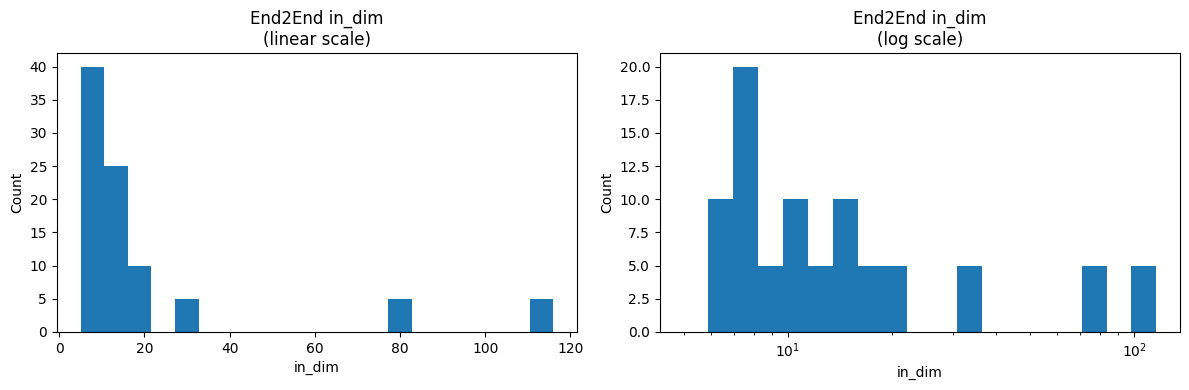

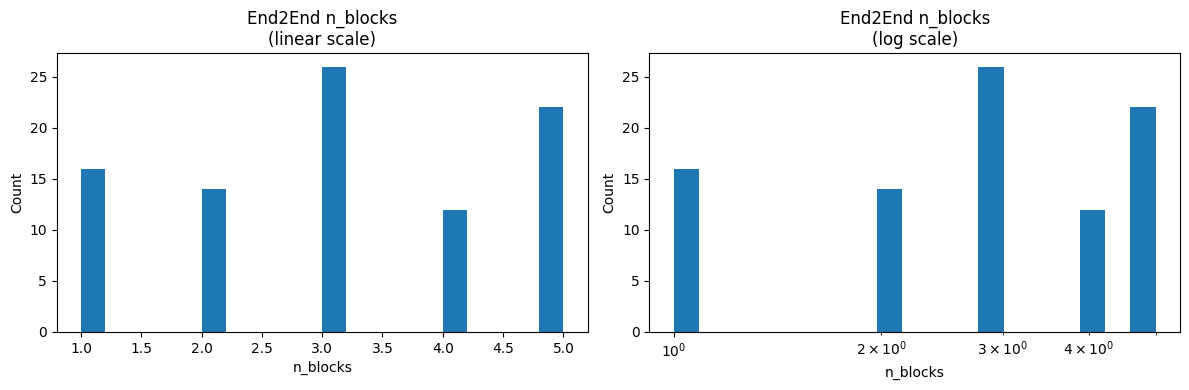

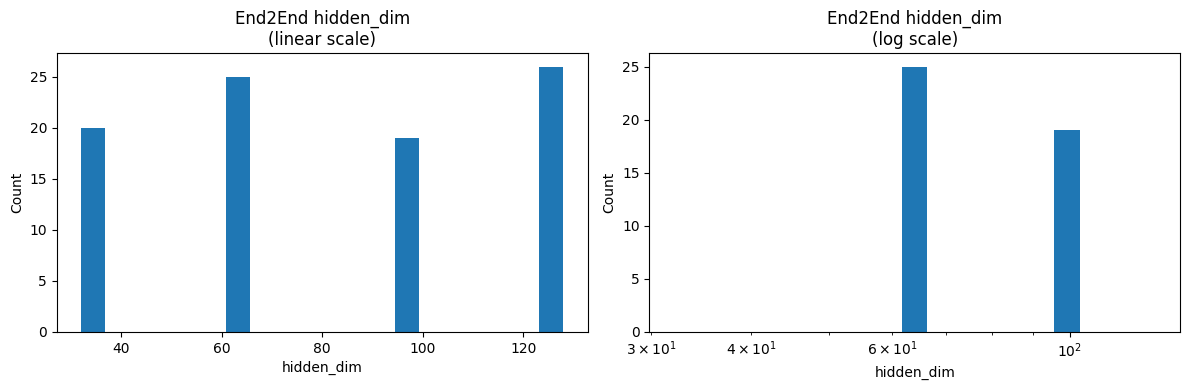

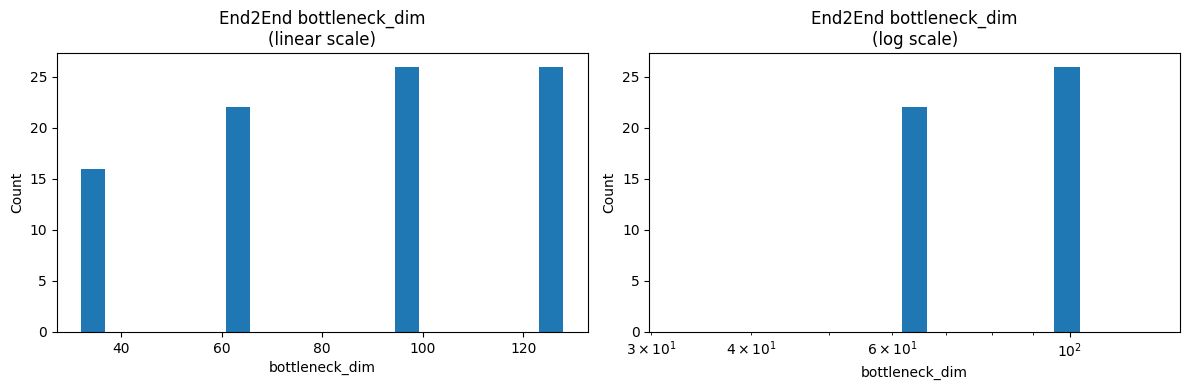

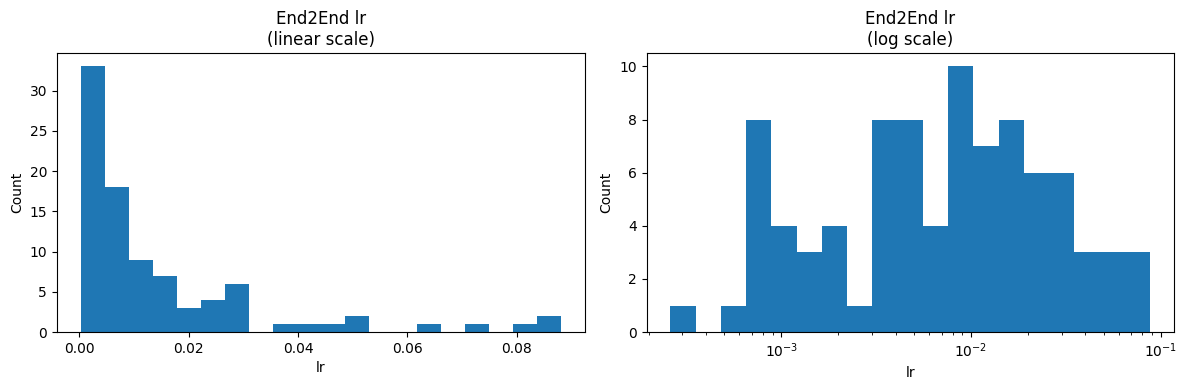

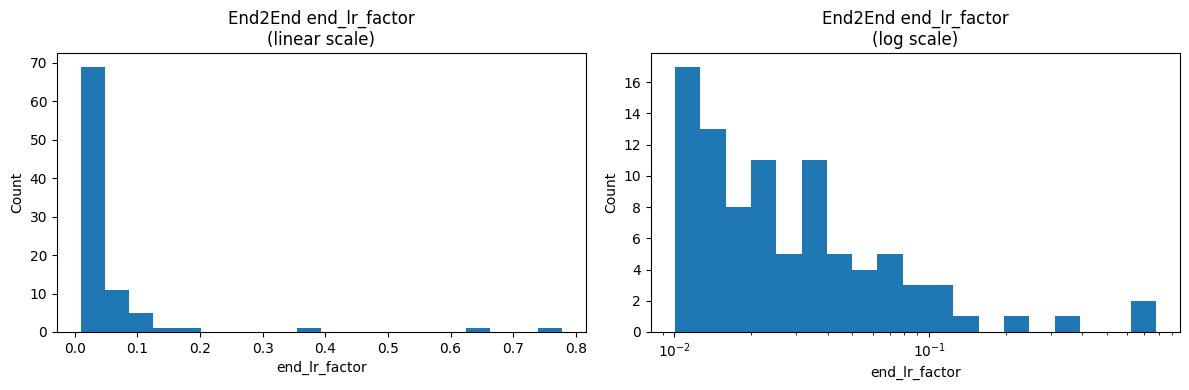

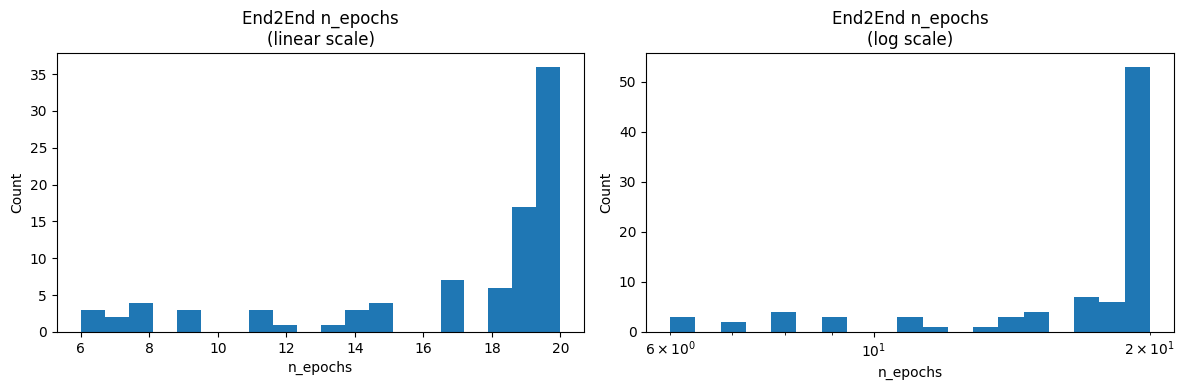

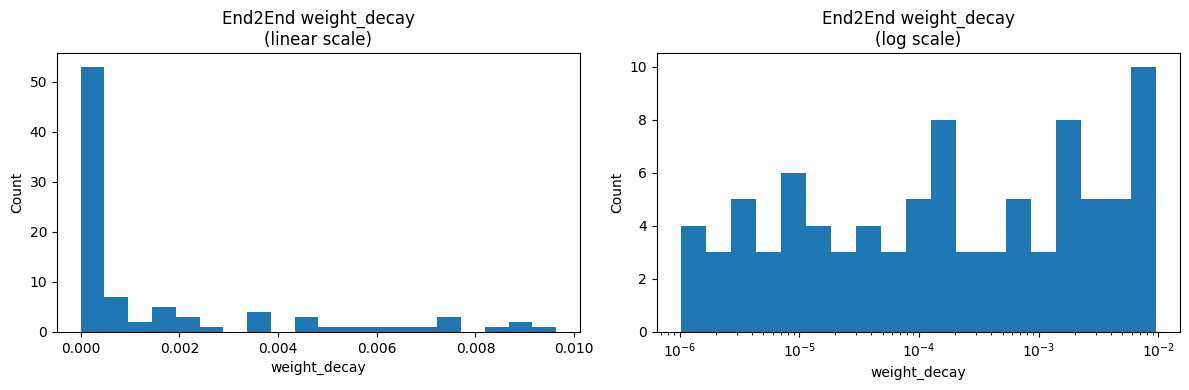

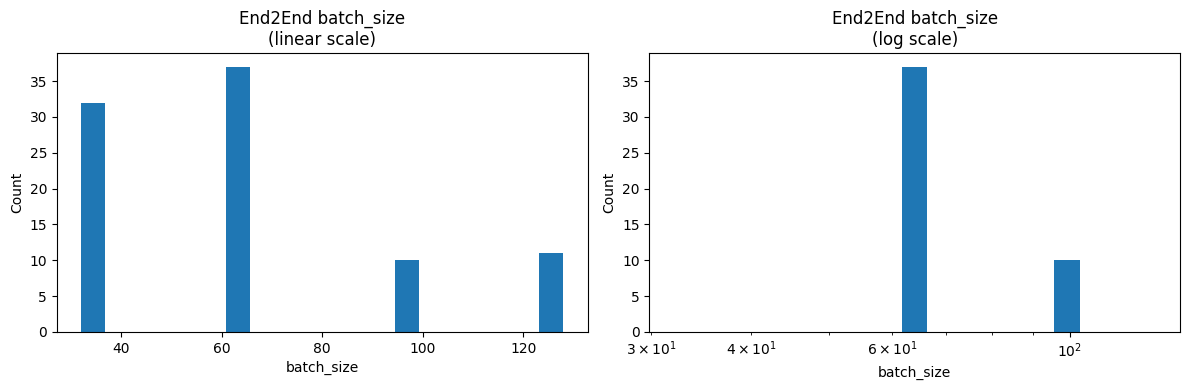

Model: Ridge


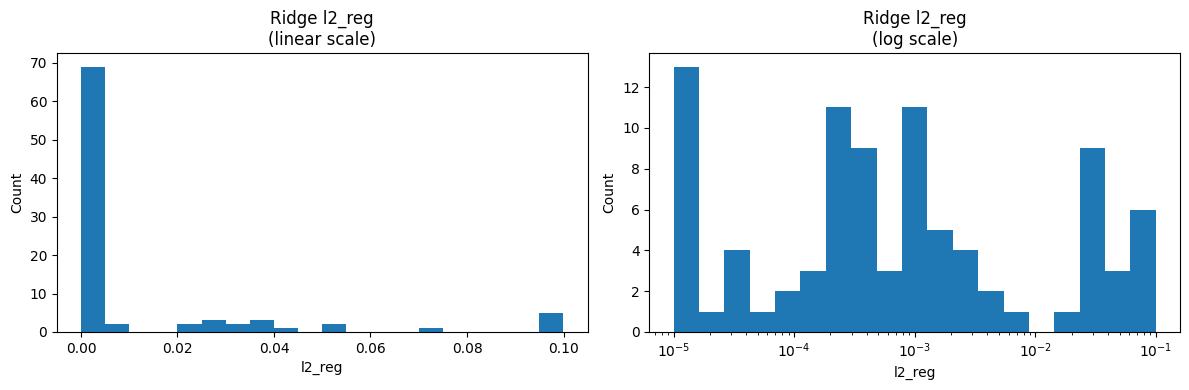

Model: RidgeCV


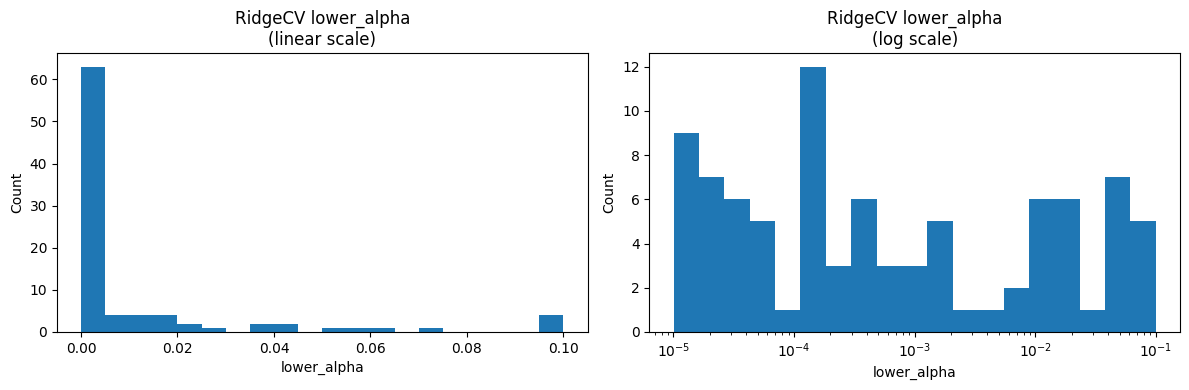

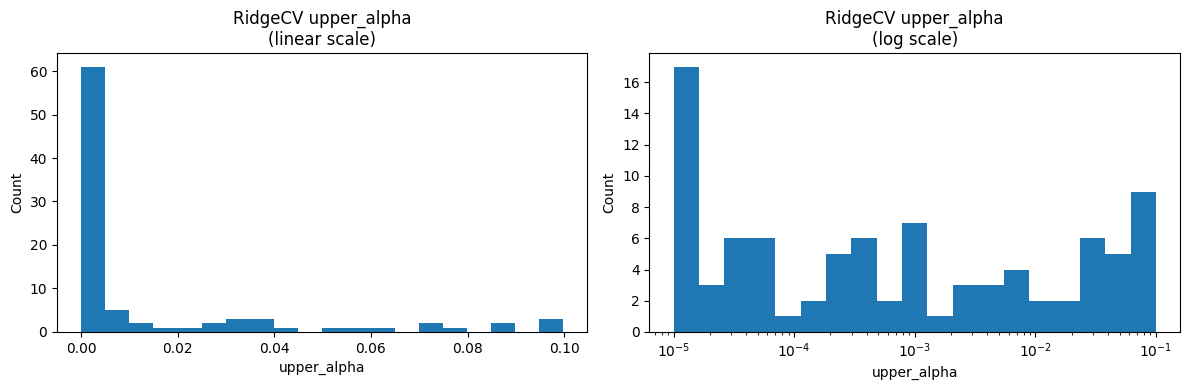

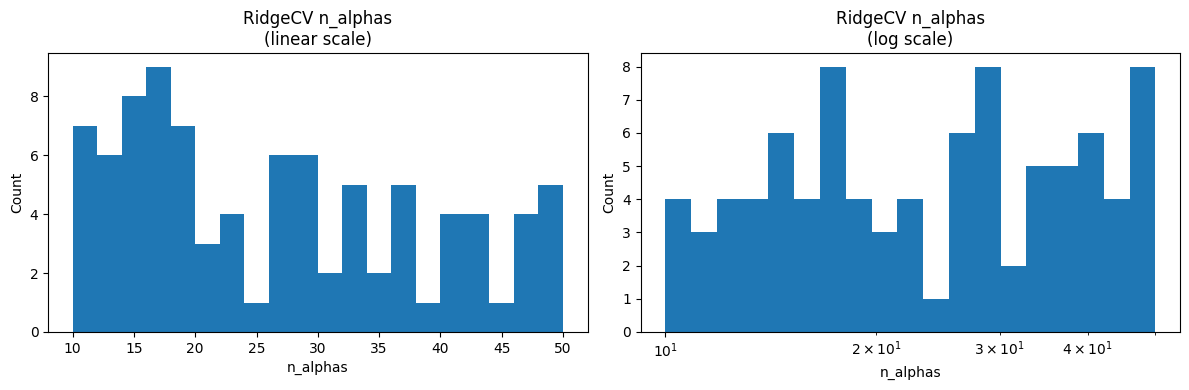

Model: XGBoostRegressor


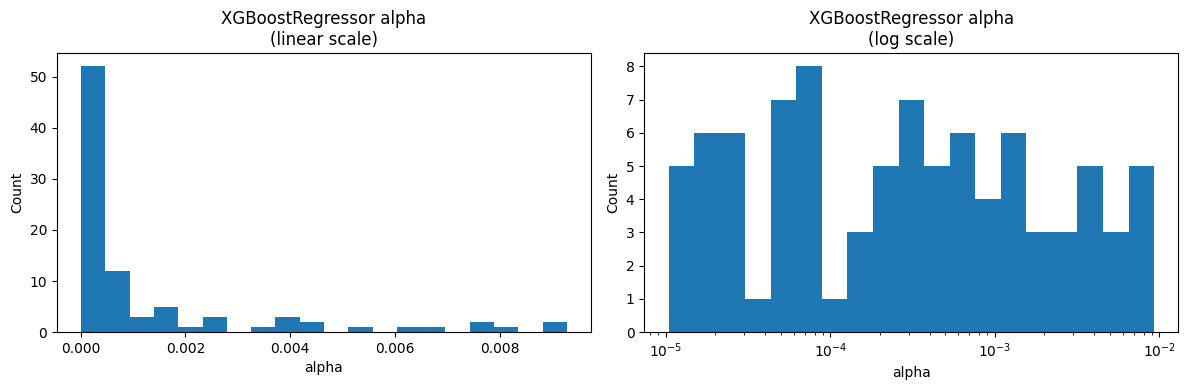

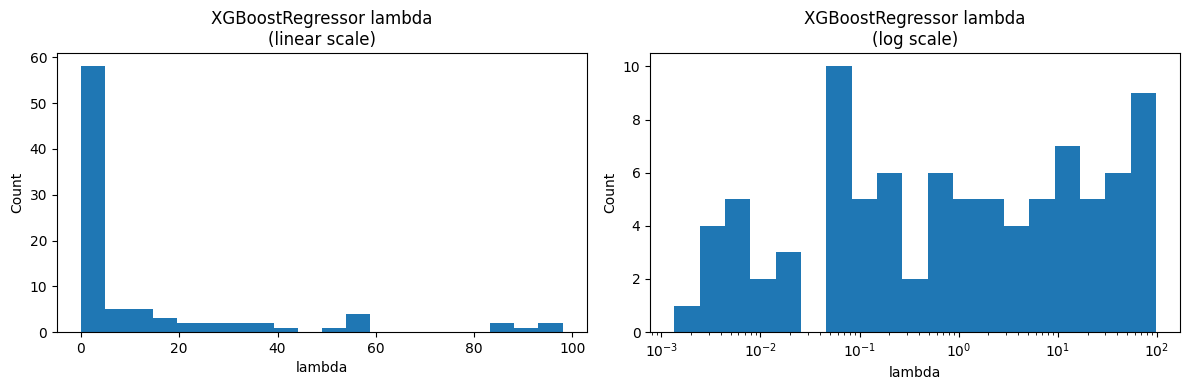

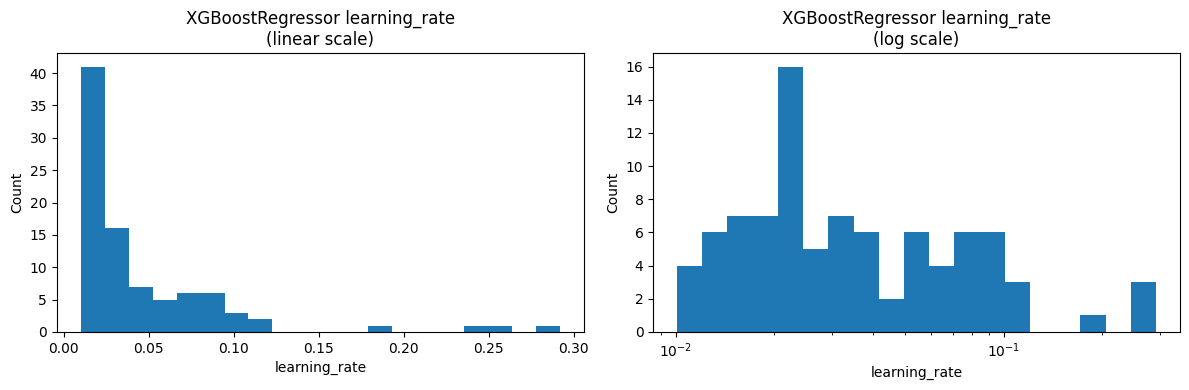

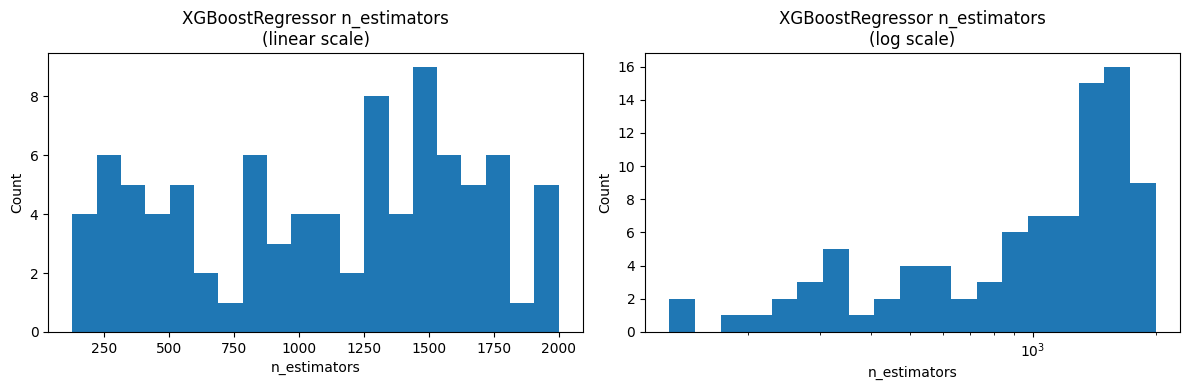

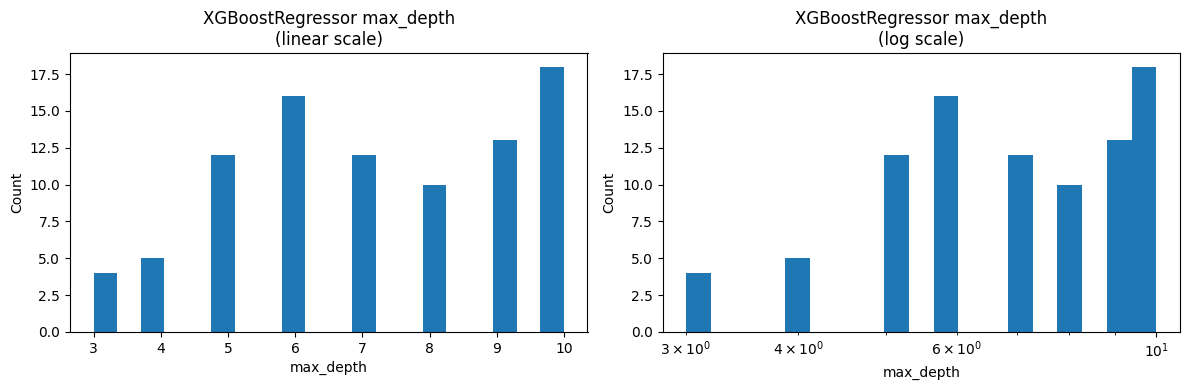

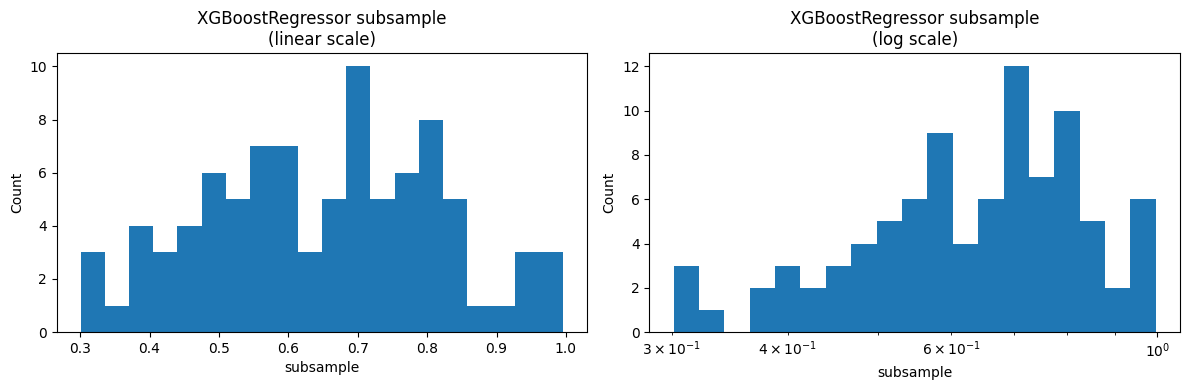

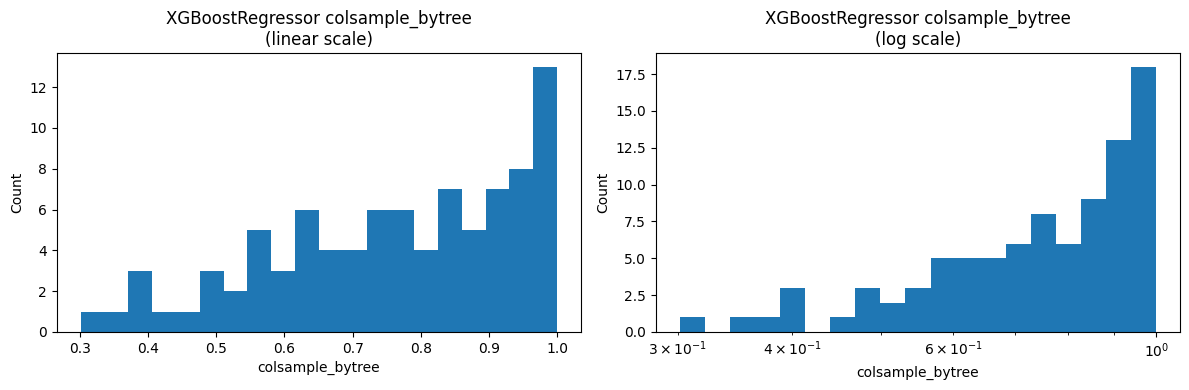

Model: GradientRFBoost


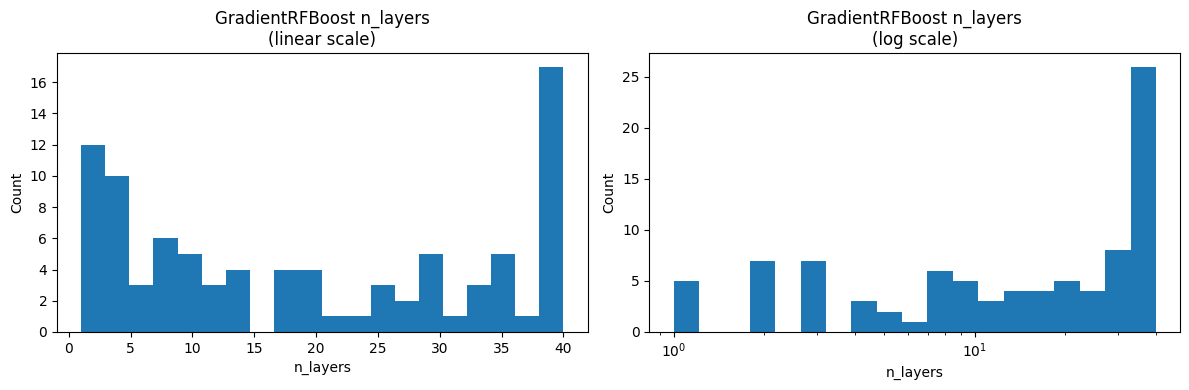

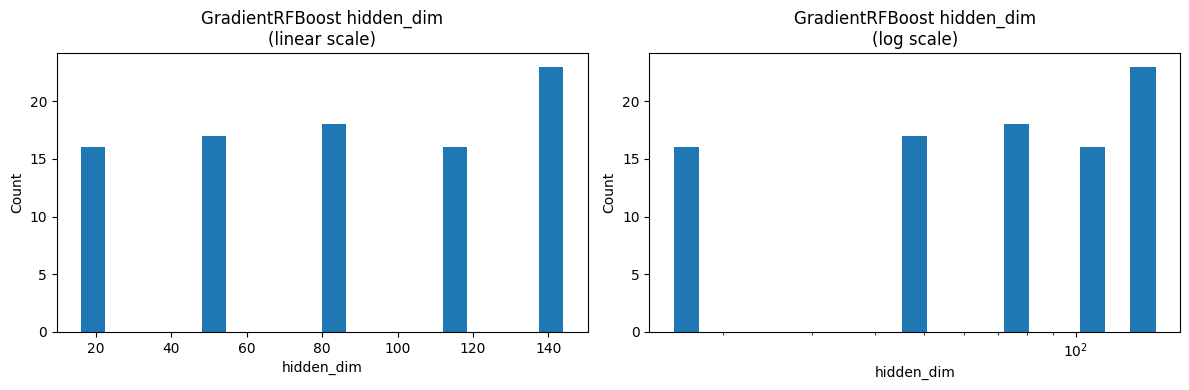

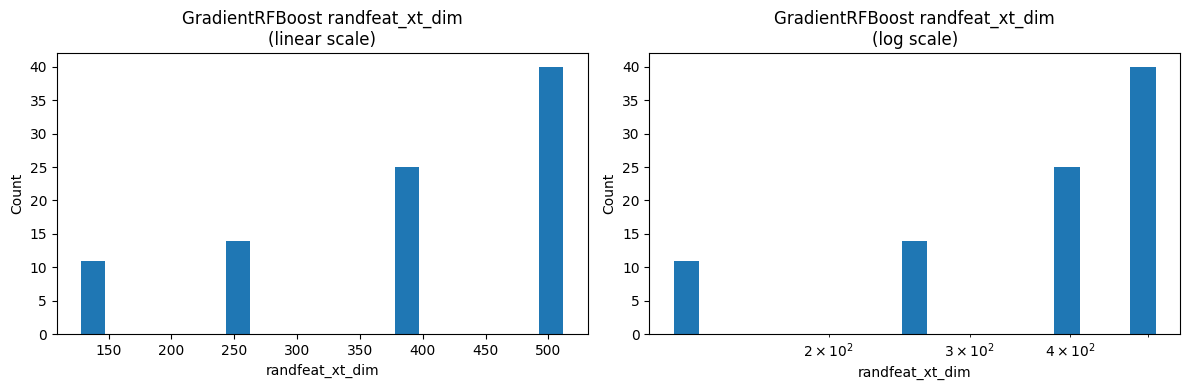

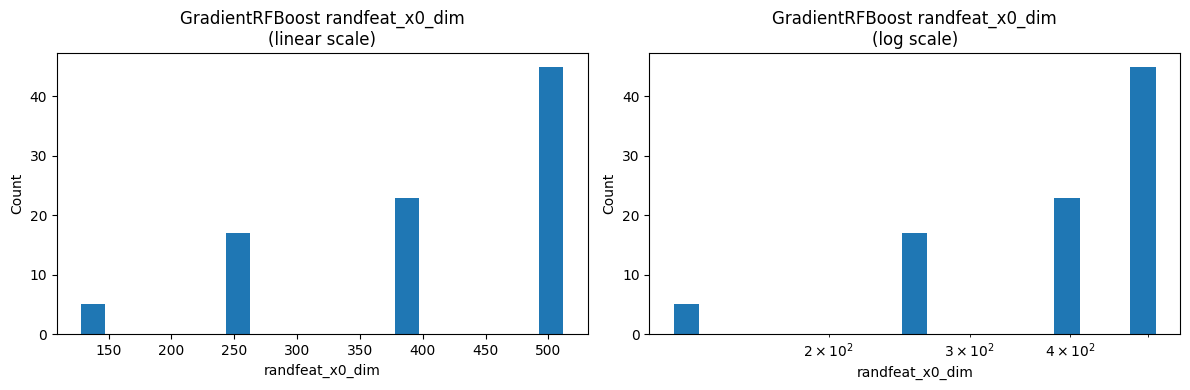

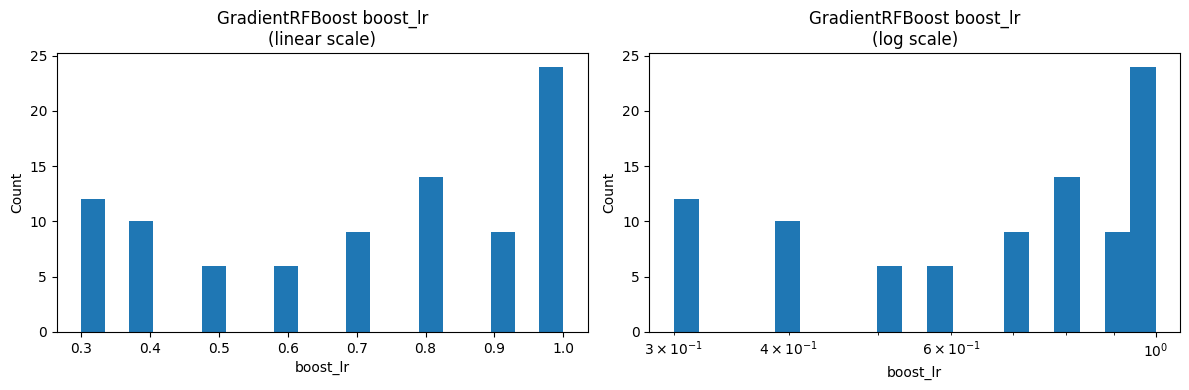

Model: GradientRFBoostID


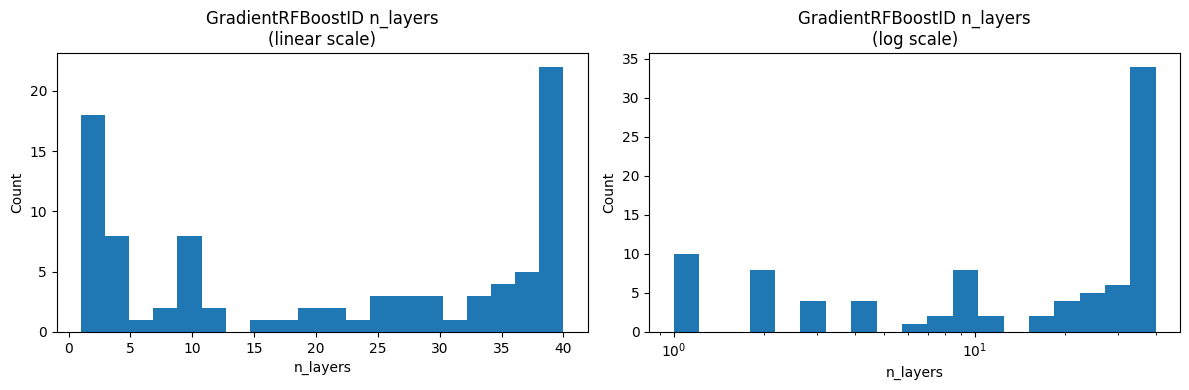

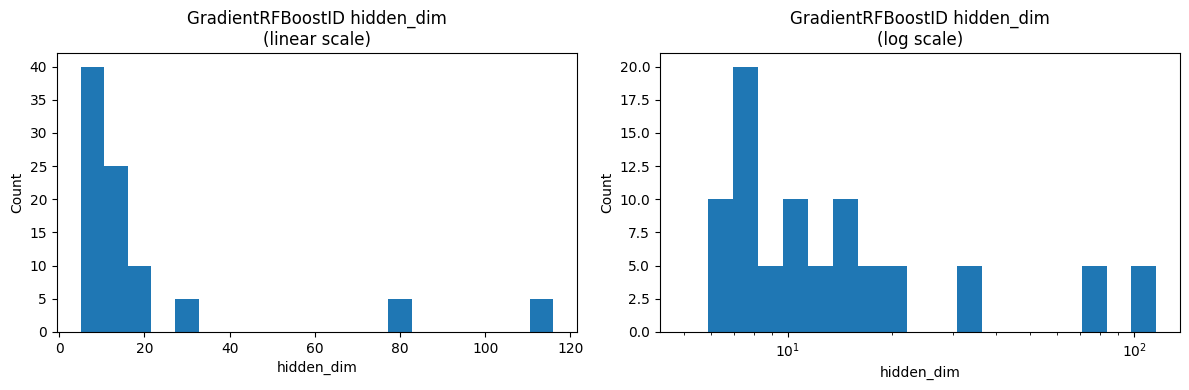

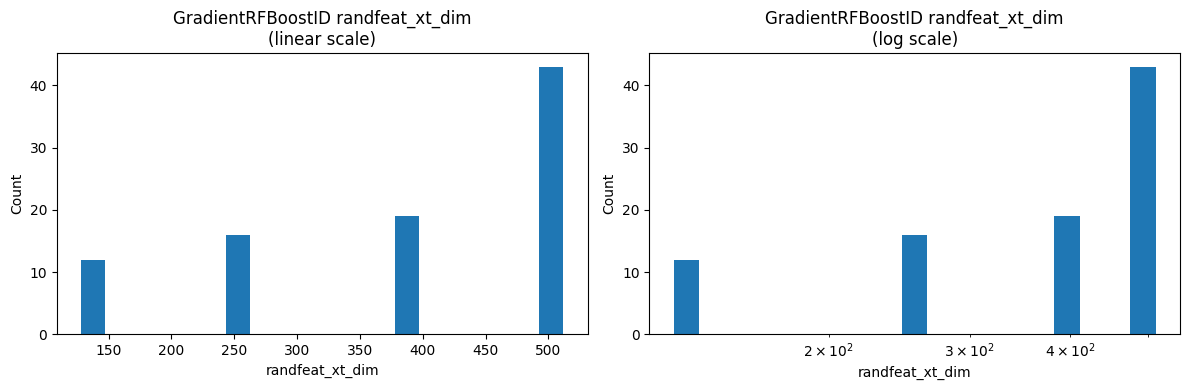

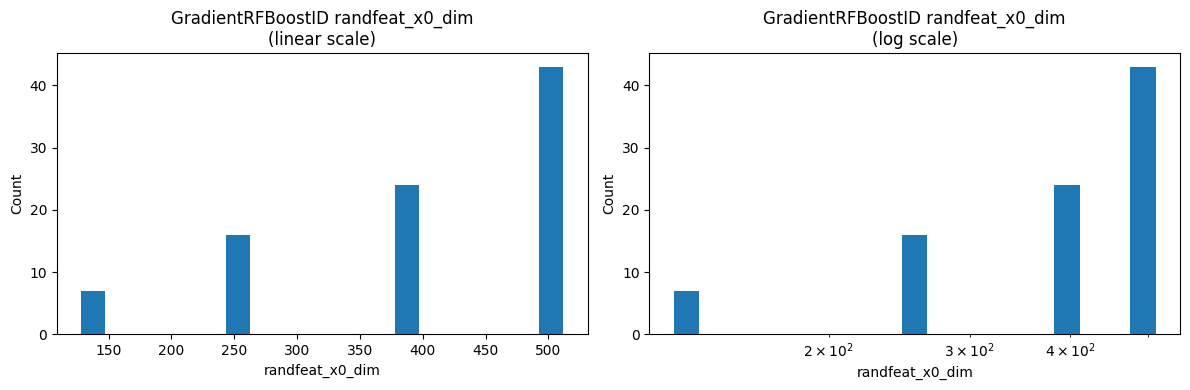

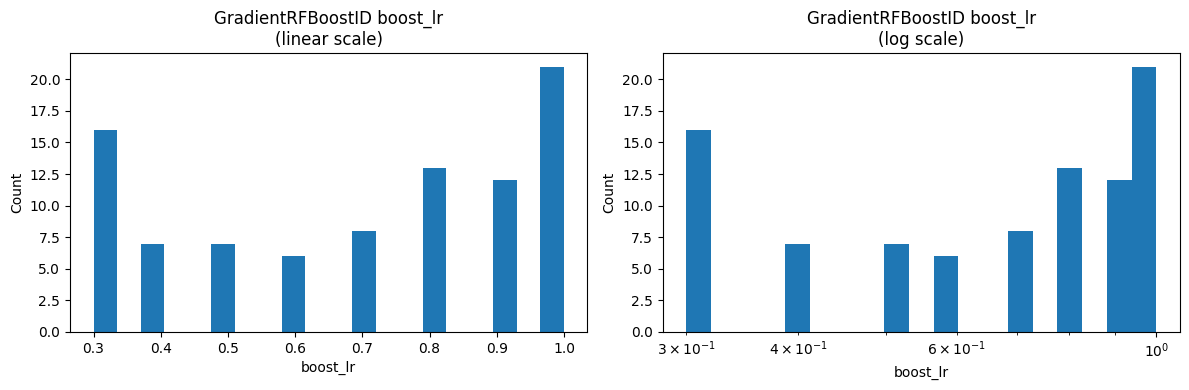

Model: GreedyRFBoostDense


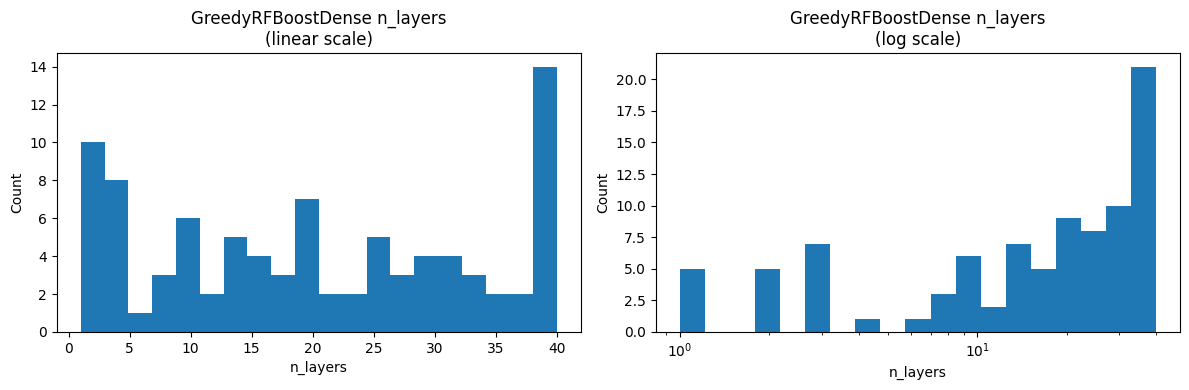

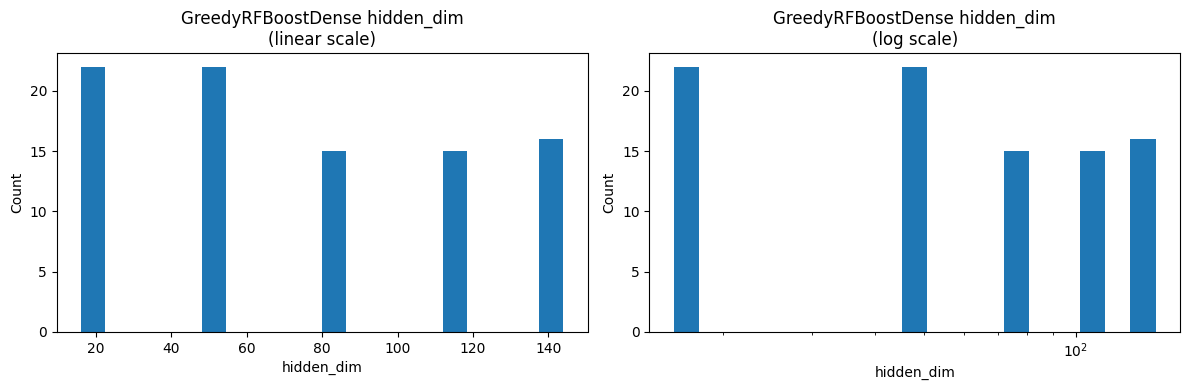

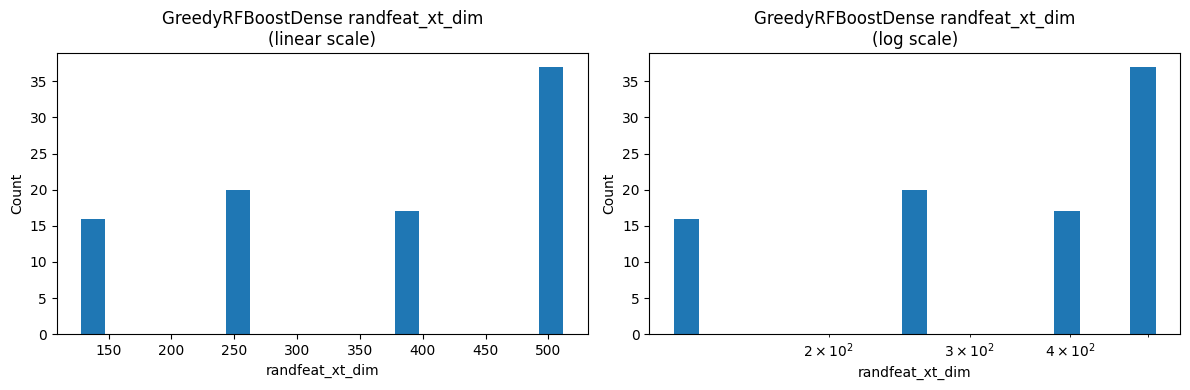

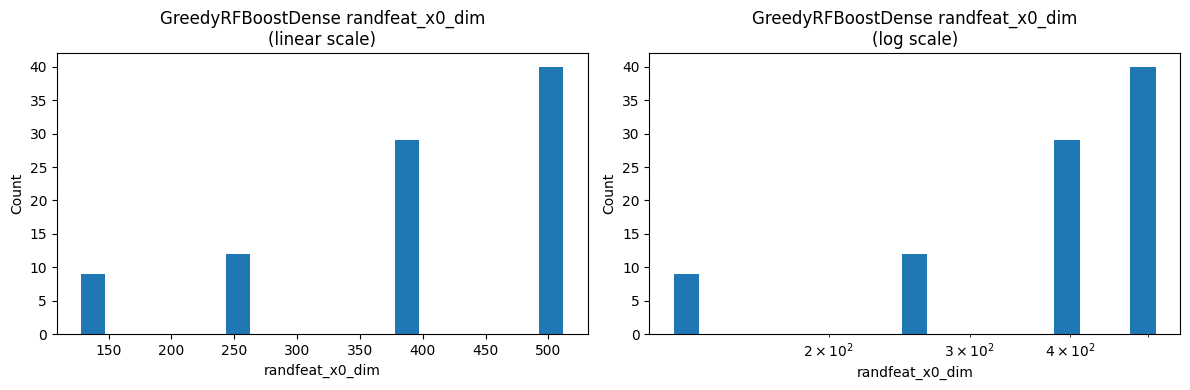

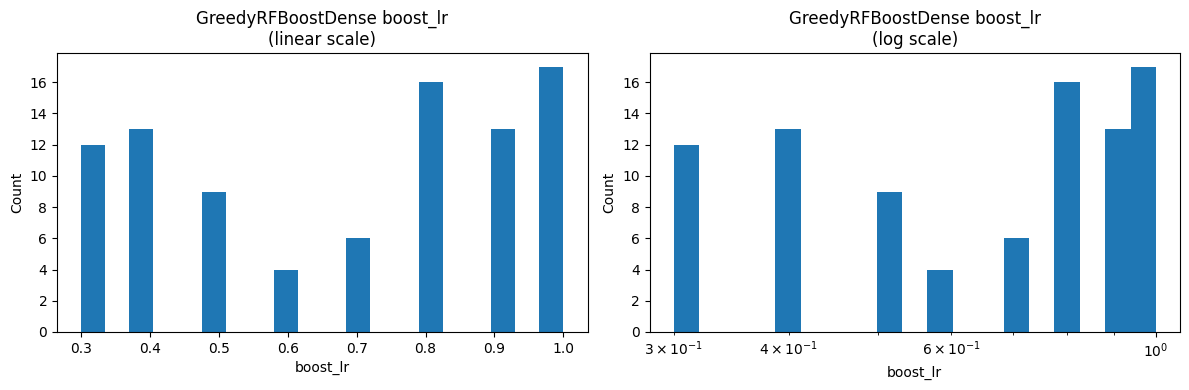

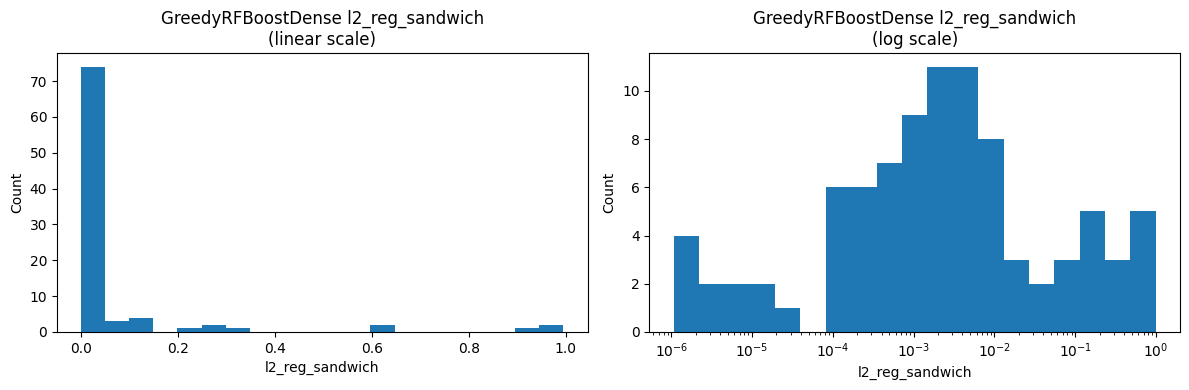

Model: GreedyRFBoostDiag


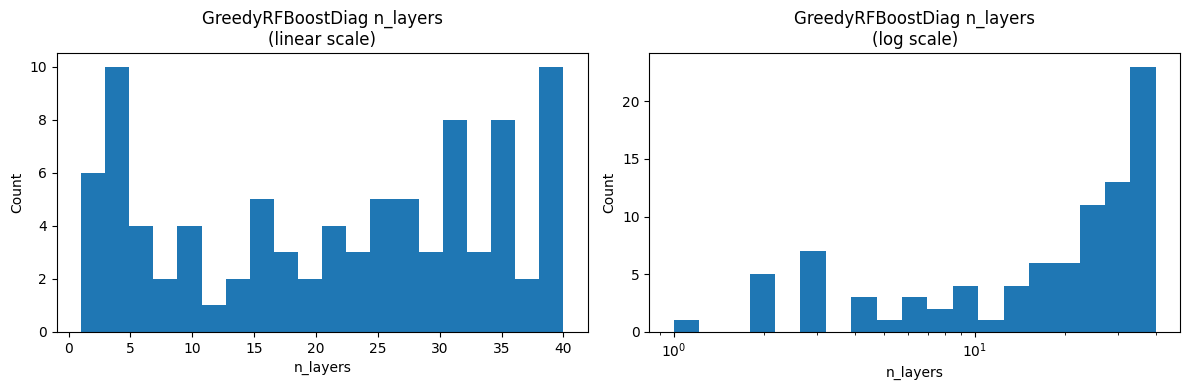

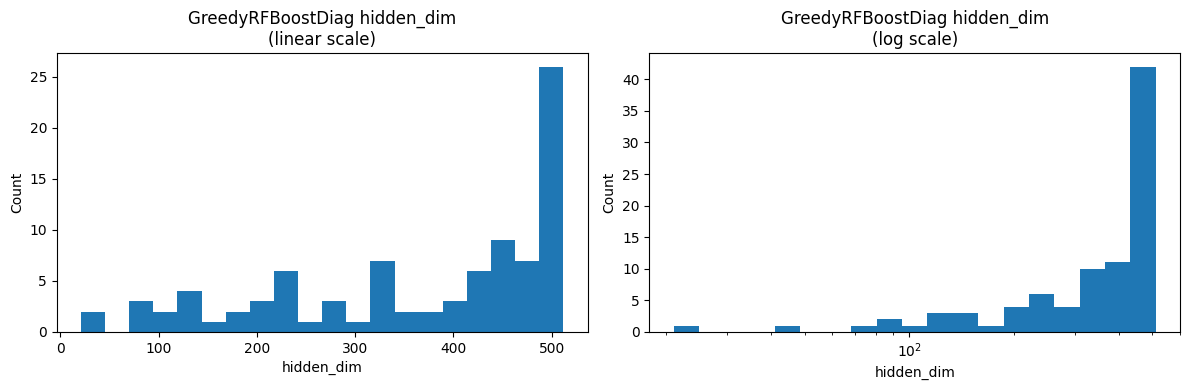

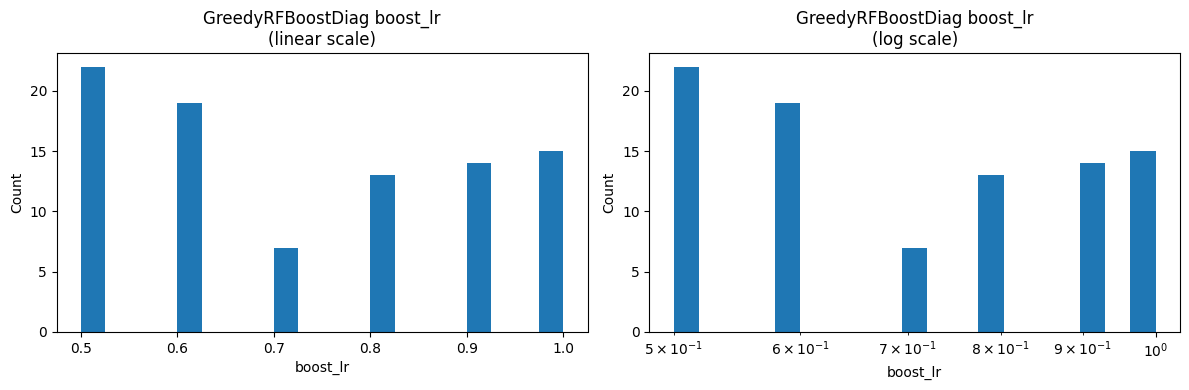

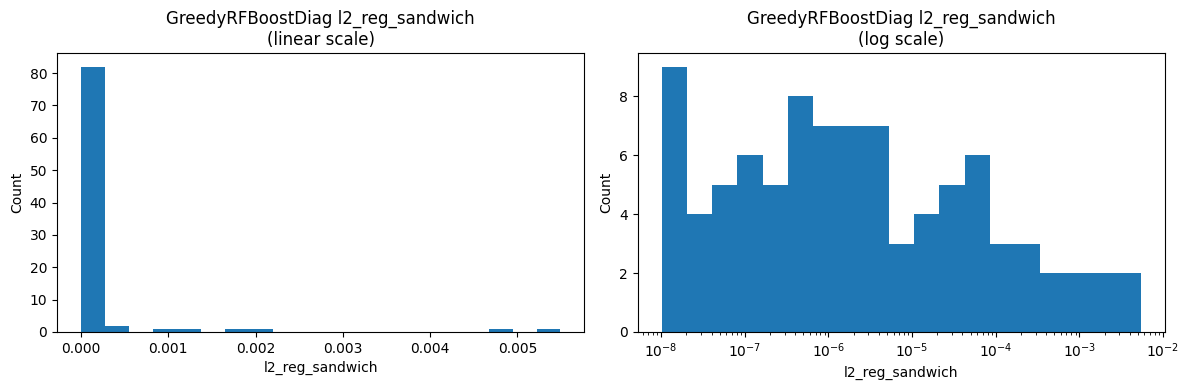

Model: GreedyRFBoostScalar


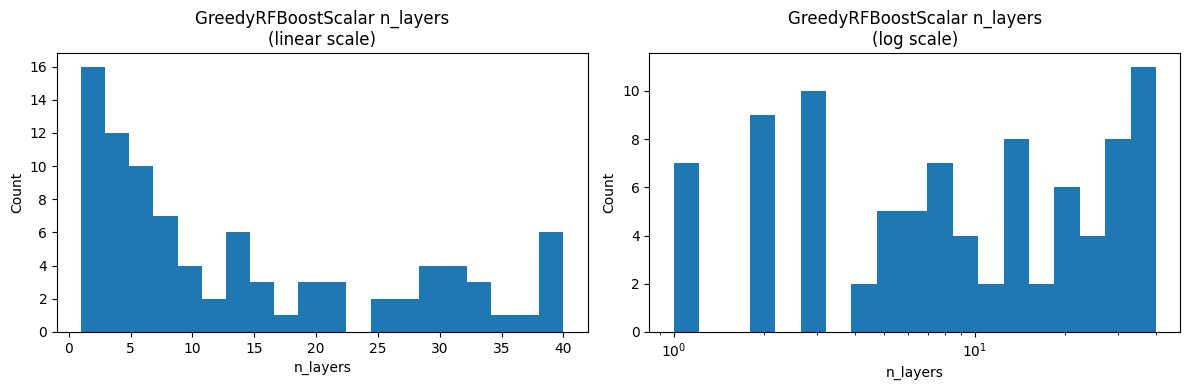

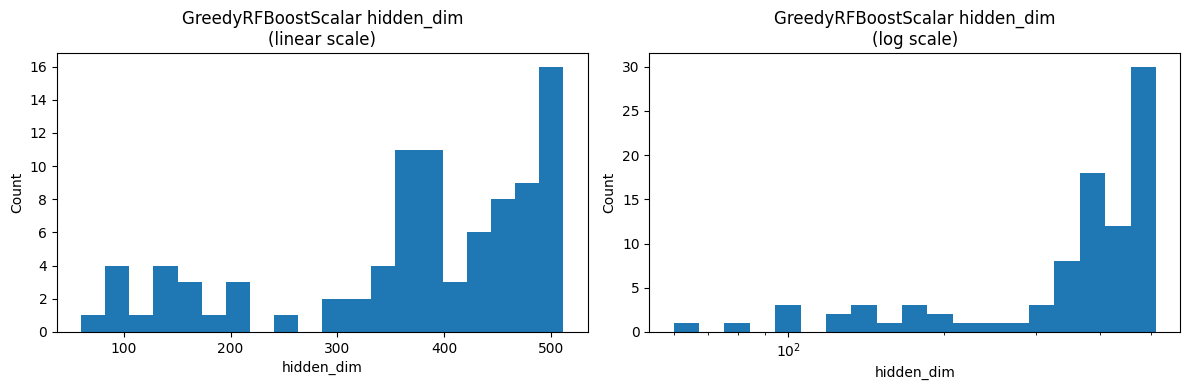

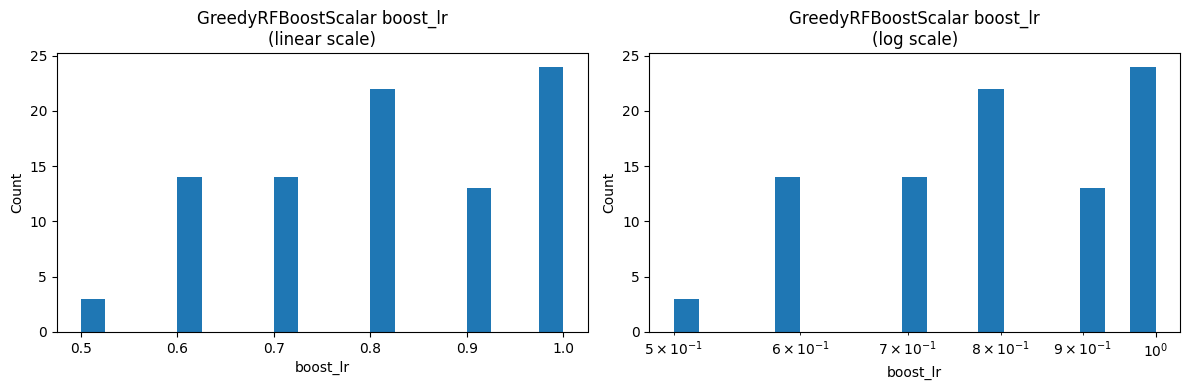

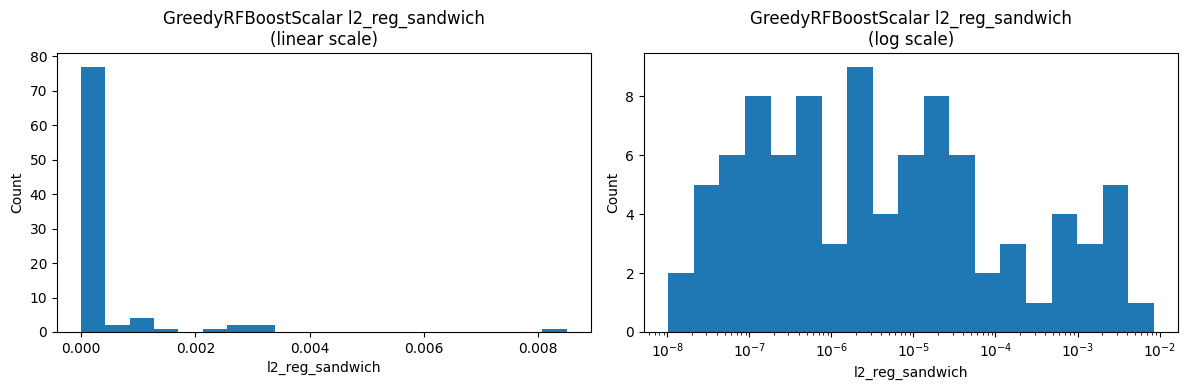

In [78]:
import matplotlib.pyplot as plt

def plot_param_distribution(
        models = ["End2End", "Ridge", "RidgeCV", "XGBoostRegressor", 
                  "GradientRFBoost", "GradientRFBoostID", 
                  "GreedyRFBoostDense", "GreedyRFBoostDiag", "GreedyRFBoostScalar"],
        datasets = openML_reg_ids_noCat[[0,1,2,3,4,5,6,7,8,9,10,      13,14,15,16,17,18,19]],
        # save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/",
        save_dir = "/home/nikita/Code/random-feature-boosting/save/regv2_added40nlayers/OpenMLRegression/",
        ):
    # Load and join the JSON data
    results_json = get_joined_results_json(models, datasets, save_dir)

    # model: list_of_param_names
    modelwise_param_names = {model: list(results_json[str(datasets[0])][model]['hyperparams'][0])
                            for model in models} 

    # model: param_name: list_of_param_values
    param_distribution = { model: {param: [] for param in param_names}
                          for model, param_names in modelwise_param_names.items()}

    #populate teh param_districution nested dict
    for dataset, dataset_results in results_json.items():
        for model_name, model_results in dataset_results.items():
            for fold in model_results["hyperparams"]:
                for param_name, param_val in fold.items():
                    param_distribution[model_name][param_name].append(param_val)

    # For each model, plot the distribution of each parameter
    for model, param_dict in param_distribution.items():
        print(f"Model: {model}")
        for param_name, param_values in param_dict.items():
            if param_name not in [
                "out_dim", "loss", "objective", "feature_type",
                "upscale", "sandwich_solver"
                ]:
                # Create figure with two subplots side by side
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
                
                # Linear scale plot
                ax1.hist(param_values, bins=20)
                ax1.set_title(f"{model} {param_name}\n(linear scale)")
                ax1.set_xlabel(param_name)
                ax1.set_ylabel("Count")
                
                # Log scale plot
                min_val = np.min(param_values)  # Avoid log(0)
                max_val = np.max(param_values)
                bins = np.logspace(np.log10(min_val), np.log10(max_val), 20)
                ax2.hist(param_values, bins=bins)
                ax2.set_xscale('log')
                ax2.set_title(f"{model} {param_name}\n(log scale)")
                ax2.set_xlabel(param_name)
                ax2.set_ylabel("Count")
                
                plt.tight_layout()
                plt.show()

plot_param_distribution()

# Experiment on a given dataset

In [ ]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable, Type
import argparse

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor, tensor
import pandas as pd

from optuna_kfoldCV import evaluate_pytorch_model_kfoldcv, evaluate_dataset_with_model, pytorch_load_openml_dataset
from models.models import GreedyRFBoostRegressor, GreedyRFBoostRegressor_ScalarDiagDelta, GradientRFBoostRegressor
from regression_param_specs import evaluate_Ridge

from sklearn.model_selection import train_test_split

# X_all, y_all = pytorch_load_abalone()
device = "cuda"
X_all, y_all = pytorch_load_openml_dataset(44975, "regression", device)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
# XGBoost:
from models.models import XGBoostRegressorWrapper, RidgeCVModule, End2EndMLPResNet

model = XGBoostRegressorWrapper(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.3,
)
model.fit(X_train, y_train)
y_pred_train = model(X_train)
y_pred_test = model(X_test)

print("XGBoost")
print(f"Train RMSE: {F.mse_loss(y_pred_train, y_train).sqrt()}")
print(f"Test RMSE {F.mse_loss(y_pred_test, y_test).sqrt()}")
print("\n")


# RidgeCV:
model = RidgeCVModule(
    lower_alpha=1e-6, upper_alpha=10, n_alphas=10
)
model.fit(X_train, y_train)
y_pred_train = model(X_train)
y_pred_test = model(X_test)

print("RidgeCV")
print(f"Train RMSE: {F.mse_loss(y_pred_train, y_train).sqrt()}")
print(f"Test RMSE {F.mse_loss(y_pred_test, y_test).sqrt()}")
print("\n")



In [ ]:
# End2EndMLPResNet:
model = End2EndMLPResNet(
    in_dim = X_train.shape[1],
    hidden_dim = X_train.shape[1],
    bottleneck_dim = 32,
    out_dim = 1,
    n_blocks = 4,
    lr = 0.1,
    end_lr_factor = 0.001,
    n_epochs = 20,
    weight_decay = 0.001,
    batch_size = 512
)
model.fit(X_train, y_train)
y_pred_train = model(X_train)
y_pred_test = model(X_test)

print("End2End")
print(f"Train RMSE: {F.mse_loss(y_pred_train, y_train).sqrt()}")
print(f"Test RMSE {F.mse_loss(y_pred_test, y_test).sqrt()}")
print("\n")

# Fit a model on a specific dataset

# GradientRFBoost

In [192]:
from models.models import FittableModule, create_layer, Identity, fit_ridge_ALOOCV, sandwiched_LS_scalar


n_layers = 40
model = GradientRFBoostRegressor(
    hidden_dim = X_train.shape[1],
    randfeat_xt_dim = 512,
    randfeat_x0_dim = 512,
    n_layers = n_layers,
    feature_type = "SWIM",
    boost_lr = 1.0,
    upscale = "identity",
)
model.fit(X_train, y_train)
rmse_test = F.mse_loss(model(X_test), y_test).sqrt()
print(f"GradientRFBoostRegressor: {rmse_test}")

GradientRFBoostRegressor: 0.02336112968623638


In [ ]:
def see_results_for_every_layer(X_train, X_test):
    with torch.no_grad():
        X0_train = X_train
        X0_test = X_test

        if model.upscale is not None:
            X_train = model.upscale_fun(X0_train)
            X_test = model.upscale_fun(X0_test)

        y_pred_train = X_train @ model.Ws[0] + model.bs[0]
        y_pred_test = X_test @ model.Ws[0] + model.bs[0]
        print(f"Train RMSE at layer 0: {F.mse_loss(y_pred_train, y_train).sqrt()}")
        print(f"Test RMSE at layer 0: {F.mse_loss(y_pred_test, y_test).sqrt()}")
        print()
        
        for t, (fxt_fun, fx0_fun, (Delta, Delta_b)) in enumerate(zip(model.layers_fxt, model.layers_fx0, model.deltas)):
            features_train = torch.cat([fxt_fun(X_train), fx0_fun(X0_train)], dim=1)
            features_test = torch.cat([fxt_fun(X_test), fx0_fun(X0_test)], dim=1)
            X_train = X_train + model.boost_lr * (features_train @ Delta + Delta_b)
            X_test = X_test + model.boost_lr * (features_test @ Delta + Delta_b)

            y_pred_train = X_train @ model.Ws[t+1] + model.bs[t+1]
            y_pred_test = X_test @ model.Ws[t+1] + model.bs[t+1]

            print(f"Train RMSE at layer {t+1}: {F.mse_loss(y_pred_train, y_train).sqrt()}")
            print(f"Test RMSE at layer {t+1}: {F.mse_loss(y_pred_test, y_test).sqrt()}")
            print()


see_results_for_every_layer(X_train, X_test)

In [ ]:
# slightly better test results by tuning l2_reg

# Dense sandwich

In [ ]:
n_layers = 40
model = GreedyRFBoostRegressor(
    hidden_dim = 100,
    randfeat_xt_dim = 256,
    randfeat_x0_dim = 256,
    n_layers = n_layers,
    feature_type = "SWIM",
    boost_lr = 0.9,
    upscale = "identity",
    l2_reg_sandwich = 0.00000001,
)
model.fit(X_train, y_train)

test_rmse = F.mse_loss(model(X_test), y_test).sqrt()
test_rmse

In [ ]:
def see_results_for_every_layer_greedy(X_train, X_test):
    with torch.no_grad():
        X0_train = X_train
        X0_test = X_test

        if model.upscale is not None:
            X_train = model.upscale_fun(X0_train)
            X_test = model.upscale_fun(X0_test)
        
        y_pred_train = X_train @ model.Ws[0] + model.bs[0]
        y_pred_test = X_test @ model.Ws[0] + model.bs[0]
        print(f"Train RMSE at layer 0: {F.mse_loss(y_pred_train, y_train).sqrt()}")
        print(f"Test RMSE at layer 0: {F.mse_loss(y_pred_test, y_test).sqrt()}")
        print()

        for t, (fxt_fun, fx0_fun, Delta) in enumerate(zip(model.layers_fxt, model.layers_fx0, model.deltas)):
            features_train = torch.cat([fxt_fun(X_train), fx0_fun(X0_train)], dim=1)
            features_test = torch.cat([fxt_fun(X_test), fx0_fun(X0_test)], dim=1)
            X_train = X_train + model.boost_lr * (features_train @ Delta)
            X_test = X_test + model.boost_lr * (features_test @ Delta)

            y_pred_train = X_train @ model.Ws[t+1] + model.bs[t+1]
            y_pred_test = X_test @ model.Ws[t+1] + model.bs[t+1]

            print(f"Train RMSE at layer {t+1}: {F.mse_loss(y_pred_train, y_train).sqrt()}")
            print(f"Test RMSE at layer {t+1}: {F.mse_loss(y_pred_test, y_test).sqrt()}")
            print()


see_results_for_every_layer_greedy(X_train, X_test)

# Diag sandwich

In [ ]:
n_layers = 40
model = GreedyRFBoostRegressor_ScalarDiagDelta(
    hidden_dim = 512,
    n_layers = n_layers,
    feature_type = "SWIM",
    boost_lr = 0.9,
    upscale = "dense",
    l2_reg_sandwich = 0.0000001,
    sandwich_solver="diag",
)
model.fit(X_train, y_train)

test_rmse = F.mse_loss(model(X_test), y_test).sqrt()
test_rmse

In [ ]:
def see_results_for_every_layer_diag_scalar(X_train, X_test):
    with torch.no_grad():
        X0_train = X_train
        X0_test = X_test

        if model.upscale is not None:
            X_train = model.upscale_fun(X0_train)
            X_test = model.upscale_fun(X0_test)

        y_pred_train = X_train @ model.Ws[0] + model.bs[0]
        y_pred_test = X_test @ model.Ws[0] + model.bs[0]
        print(f"Train RMSE at layer 0: {F.mse_loss(y_pred_train, y_train).sqrt()}")
        print(f"Test RMSE at layer 0: {F.mse_loss(y_pred_test, y_test).sqrt()}")
        print()

        for t, (layer, Delta) in enumerate(zip(model.layers, model.deltas)):
            features_train = layer(torch.cat([X_train, X0_train], dim=1))
            features_test = layer(torch.cat([X_test, X0_test], dim=1))
            X_train = X_train + model.boost_lr * model.XDelta_op(features_train, Delta)
            X_test = X_test + model.boost_lr * model.XDelta_op(features_test, Delta)

            y_pred_train = X_train @ model.Ws[t+1] + model.bs[t+1]
            y_pred_test = X_test @ model.Ws[t+1] + model.bs[t+1]

            print(f"Train RMSE at layer {t+1}: {F.mse_loss(y_pred_train, y_train).sqrt()}")
            print(f"Test RMSE at layer {t+1}: {F.mse_loss(y_pred_test, y_test).sqrt()}")
            print()


see_results_for_every_layer_diag_scalar(X_train, X_test)

# Scalar sandwich

In [ ]:
n_layers = 40
model = GreedyRFBoostRegressor_ScalarDiagDelta(
    hidden_dim = 512,
    n_layers = n_layers,
    feature_type = "SWIM",
    boost_lr = 0.9,
    upscale = "dense",
    l2_reg_sandwich = 0.000001,
    sandwich_solver="scalar",
)
model.fit(X_train, y_train)

test_rmse = F.mse_loss(model(X_test), y_test).sqrt()
print(test_rmse)


see_results_for_every_layer_diag_scalar(X_train, X_test)

In [ ]:
# XGBoosted randFeats --- better! (i hope also after tuning params)

# XGBoost:
from models.models import XGBoostRegressorWrapper, RidgeCVModule, End2EndMLPResNet
from models.models import FittableModule, create_layer, Identity, fit_ridge_ALOOCV, sandwiched_LS_scalar


n_layers = 20
model = GradientRFBoostRegressor(
    hidden_dim = X_train.shape[1],
    randfeat_xt_dim = 512,
    randfeat_x0_dim = 512,
    n_layers = n_layers,
    feature_type = "SWIM",
    boost_lr = 0.7,
    upscale = "identity",
)
model.fit(X_train, y_train)
rmse_test = F.mse_loss(model(X_test), y_test).sqrt()
print(f"GradientRFBoostRegressor: {rmse_test}")

def get_boosted_features(model, X_train, X_test):
    with torch.no_grad():
        X0_train = X_train
        X0_test = X_test

        if model.upscale is not None:
            X_train = model.upscale_fun(X0_train)
            X_test = model.upscale_fun(X0_test)

        y_pred_train = X_train @ model.Ws[0] + model.bs[0]
        y_pred_test = X_test @ model.Ws[0] + model.bs[0]
        print(f"Train RMSE at layer 0: {F.mse_loss(y_pred_train, y_train).sqrt()}")
        print(f"Test RMSE at layer 0: {F.mse_loss(y_pred_test, y_test).sqrt()}")
        print()
        
        for t, (fxt_fun, fx0_fun, (Delta, Delta_b)) in enumerate(zip(model.layers_fxt, model.layers_fx0, model.deltas)):
            features_train = torch.cat([fxt_fun(X_train), fx0_fun(X0_train)], dim=1)
            features_test = torch.cat([fxt_fun(X_test), fx0_fun(X0_test)], dim=1)
            X_train = X_train + model.boost_lr * (features_train @ Delta + Delta_b)
            X_test = X_test + model.boost_lr * (features_test @ Delta + Delta_b)

            y_pred_train = X_train @ model.Ws[t+1] + model.bs[t+1]
            y_pred_test = X_test @ model.Ws[t+1] + model.bs[t+1]

            print(f"Train RMSE at layer {t+1}: {F.mse_loss(y_pred_train, y_train).sqrt()}")
            print(f"Test RMSE at layer {t+1}: {F.mse_loss(y_pred_test, y_test).sqrt()}")
            print()
    return X_train, X_test

xgb = XGBoostRegressorWrapper(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.3,
)
boosted_features_train, boosted_features_test = get_boosted_features(model, X_train, X_test)
xgb.fit(boosted_features_train, y_train)
y_pred_train = xgb(boosted_features_train)
y_pred_test = xgb(boosted_features_test)

print("XGBoost")
print(f"Train RMSE: {F.mse_loss(y_pred_train, y_train).sqrt()}")
print(f"Test RMSE {F.mse_loss(y_pred_test, y_test).sqrt()}")
print("\n")